In [2]:
# data, system tools
import pandas as pd
import numpy as np
import os
import glob
import itertools

# multiprocessing
import multiprocessing as mp
from functools import partial

# stats
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statannot
import scipy
import scipy.stats

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [3]:
from nilearn import plotting
def draw_custom_colorbar(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True,
                         format="%.1f", cmap=plotting.cm.cold_hot, tick_left=True, tick_right=False, is_symmetric=True,
                         orientation='vertical', label=''):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = cmap
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    
    if nb_ticks > 0:
        ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    else:
        ticks = []
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    if is_symmetric:
        norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation=orientation, cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format=format, label=label)
    
    if flip:
        colorbar_ax.invert_yaxis()
    if tick_left:
        colorbar_ax.yaxis.tick_left()
    if tick_right:
        colorbar_ax.yaxis.tick_right()

    return colorbar_ax

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
pretty_names_map = {
    'AMG': 'Amygdala',
    'CL': 'Claustrum',
    'fx': 'Fornix',
    'GPe': 'Globus pallidus externa',
    'GPi': 'Globus pallidus interna',
    'ic': 'Internal capsule',
    'LV': 'Ventricles (lateral)',
    'PAG': 'Periaquaductal gray',
    'PPN': 'Pedunculopontine nucleus',
    'RN': 'Red nucleus',
    'SN': 'Substantia nigra',
    'STN': 'Subthalamic nucleus',
    'STR': 'Striatum',
    'THA': 'Thalamus',
    '3V': 'Ventricle 3',
    '4V': 'Ventricle 4',
    'VTA': 'Ventral tegmental area',
}

In [5]:
# Load data
final_table_absolute = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional.pkl')
final_table_location = pd.read_pickle('../data/interim_data/summary_table_location.pkl')*2  # multiply because the models are in 0.5mm space, so scale becomes mm
final_table_location.columns = final_table_location.columns.droplevel([0])
final_table_absolute = pd.merge(final_table_location, final_table_absolute, left_index=True, right_index=True, how='outer')

# reorder cols, reindex rows
final_table_absolute = final_table_absolute.reindex(['AMG', 'CL', 'fx', 'GPe', 'GPi', 'ic', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VTA', 'LV', '3V', '4V'])
multi_tuples = [('iron', 'median'), ('myelin', 'median'), ('iron', 'iqr'), ('myelin', 'iqr'), ('volume', 'volume'), ('thickness', 'median'), ('thickness', 'iqr'),
                ('location', 'X_mni_abs'), ('location', 'Y_mni'), ('location', 'Z_mni')]
multi_cols = pd.MultiIndex.from_tuples(multi_tuples, names=['metric', 'Statistic'])
final_table_absolute = final_table_absolute[multi_cols]

# Remove VENT iron/myelin, these don't make theoretical sense
final_table_absolute.loc['LV', 'iron'] = 0
final_table_absolute.loc['LV', 'myelin'] = 0
final_table_absolute.loc['3V', 'iron'] = 0
final_table_absolute.loc['3V', 'myelin'] = 0
final_table_absolute.loc['4V', 'iron'] = 0
final_table_absolute.loc['4V', 'myelin'] = 0
final_table_absolute

# get SEs
bootstrapped_SE = pd.read_pickle('../data/bootstraps/all_bootstrapped_data_n=10000.pkl')
bootstrapped_SE['SE'] = bootstrapped_SE['bootstrap_results'].apply(lambda x: x['relative_mean_change_unsigned']['SE'])
bootstrapped_SE = bootstrapped_SE.pivot_table(values='SE', index='ROI', columns=['qMRI', 'Statistic'])

bootstrapped_SE_location = pd.read_pickle('../data/bootstraps/all_bootstrapped_location_data_n=10000.pkl')
bootstrapped_SE_location['SE'] = bootstrapped_SE_location['bootstrap_results'].apply(lambda x: x['absolute_mean_change']['SE'])
bootstrapped_SE_location = bootstrapped_SE_location.pivot_table(values='SE', index='ROI', columns=['metric', 'Statistic'])

bootstrapped_SE = pd.merge(bootstrapped_SE, bootstrapped_SE_location, left_index=True, right_index=True, how='outer')[multi_cols]
bootstrapped_SE = bootstrapped_SE.loc[final_table_absolute.index]

In [24]:
## Export for spider chart
radar_chart_data = final_table_absolute.reset_index().copy()
radar_chart_data = radar_chart_data.loc[~radar_chart_data.ROI.isin(['3V', '4V', 'LV'])].sort_values('ROI').set_index('ROI')
radar_chart_data = radar_chart_data.iloc[:,:7]
radar_chart_data.columns = ['_'.join(x) for x in radar_chart_data.columns]
radar_chart_data.to_csv('../data/radar_chart_data.csv', sep='\t')

## Correlation between median and iron IQR changes?

In [5]:
%load_ext rpy2.ipython
from scipy import stats
import statsmodels

In [6]:
median_values = final_table_absolute.loc[final_table_absolute.index[:-3], ('iron', 'median')]
iqr_values = final_table_absolute.loc[final_table_absolute.index[:-3], ('iron', 'iqr')]
stats.pearsonr(median_values, iqr_values)

(0.5978704779755512, 0.02393359328597923)

In [7]:
%%R -i median_values -i iqr_values

cor.test(median_values, iqr_values)


	Pearson's product-moment correlation

data:  median_values and iqr_values
t = 2.5837, df = 12, p-value = 0.02393
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09855409 0.85669201
sample estimates:
      cor 
0.5978705 



In [8]:
median_values = final_table_absolute.loc[final_table_absolute.index[:-3], ('myelin', 'median')]
iqr_values = final_table_absolute.loc[final_table_absolute.index[:-3], ('myelin', 'iqr')]

stats.pearsonr(median_values, iqr_values)

(-0.37572932787386315, 0.18552996778670497)

In [9]:
%%R -i median_values -i iqr_values

cor.test(median_values, iqr_values)


	Pearson's product-moment correlation

data:  median_values and iqr_values
t = -1.4045, df = 12, p-value = 0.1855
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.7556640  0.1934066
sample estimates:
       cor 
-0.3757293 



## Single plot for absolute, separate colormaps per "Change type"

In [10]:
def get_cell_colors(table, cmap, max_value, vmax=256, vmin=0):
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
        
    def norm(x, x_max=max_value, vmax=vmax, vmin=vmin):
        return int(vmax/2 + (x/x_max)*(vmax-vmin)/2)

    def get_hex(value, cmap, **kwargs):
        rgb = cmap(norm(value, **kwargs))[:3]   # no alpha
        return matplotlib.colors.rgb2hex(rgb)

    # make RGB table
    color_table_rgb = np.empty((table.shape[0], table.shape[1], 3))
    color_table_hex = table.copy()
    for row in range(table.shape[0]):
        for col in range(table.shape[1]):
            x = get_hex(table.iloc[row, col], cmap=cmap)
            color_table_hex.iloc[row, col] = x
            color_table_rgb[row, col, :] = cmap(norm(table.iloc[row, col]))[:3]
    return color_table_rgb

## With volume

In [11]:
plot_dict = {'medians': [100, [0,1], '%'],
             'IQRs': [100, [2,3], '%'],
             'volume': [100, [4], '%'],
             'thickness': [100, [5,6], '%'],
             'location': [15, [7,8,9], 'mm']
             }

colorbar_grid_offset = 0.2
title_label_map = {'median': 'Median',
                   'volume': '',
                   'iqr': 'IQR',
                   'X_mni_abs': 'M-L',
                   'Y_mni': 'A-P',
                   'Z_mni': 'I-S'}

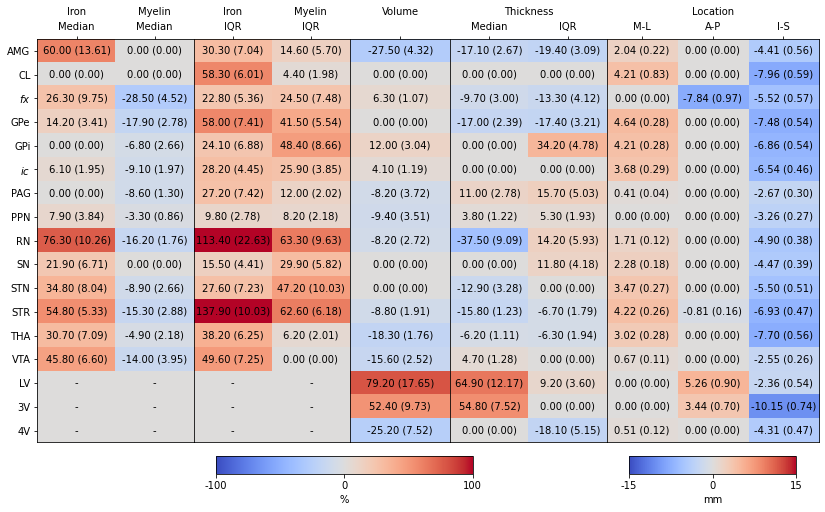

In [12]:
## add SE
## Grid should be 4 wide, at least 2 high (colorbars below!)
fig = plt.Figure(figsize=(14,8))
width_ratios = np.array([colorbar_grid_offset, 1, colorbar_grid_offset, 
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 0.5, colorbar_grid_offset,  # I guess
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1.5, colorbar_grid_offset])
width_ratios /= width_ratios.sum()
#width_ratios
gs = plt.GridSpec(3, width_ratios.shape[0], figure=fig, 
                  width_ratios=width_ratios, hspace=0.1, wspace=0,
                  height_ratios=[0.1, 1, .05])

ax = []
for c, (column, (max_value, column_ilocs, label)) in enumerate(plot_dict.items()):
    c = c*3+1
    ax.append(fig.add_subplot(gs[:2,(c-1):(c+2)]))

    this_table = final_table_absolute.iloc[:,column_ilocs]
    this_SE_table = bootstrapped_SE.iloc[:,column_ilocs]
    if column != 'location':
        this_table *= 100
        this_SE_table *= 100
    color_table_rgb = get_cell_colors(this_table, cmap='coolwarm', max_value=max_value)
    # combine in plot of table
    ax[-1].imshow(color_table_rgb, aspect='auto')
    for i in range(len(this_table)):   # rows
        for j in range(len(this_table.columns)):
#             if column == 'location' and i == 2:  # FX location should be '-'
#                 ax[-1].text(j, i, '-',
#                         ha="center", va="center", color='black')
            if column in ['medians', 'IQRs'] and ('LV' in this_table.index.values[i] or '3V' in this_table.index.values[i] or '4V' in this_table.index.values[i]):
                ax[-1].text(j, i, '-',
                        ha="center", va="center", color='black')
            else:
                ax[-1].text(j, i, '{:.2f} ({:.2f})'.format(this_table.values[i, j], this_SE_table.values[i,j]),
                        ha="center", va="center", color='black')
    if c > 3:
        ax[-1].set_yticks([])
    else:
        ax[-1].set_yticks(ticks=np.arange(this_table.shape[0]))
        ax[-1].set_yticklabels(['$'+x+'$' if x in ['fx', 'ic'] else x for x in this_table.index.values if x in pretty_names_map.keys()])#[x for x in this_table.index.values if x in pretty_names_map.keys()])
#         ax[-1].set_yticklabels([pretty_names_map[x] for x in this_table.index.values if x in pretty_names_map.keys()])
        
    ax[-1].set_xticks(ticks=np.arange(this_table.shape[1]))
    ax[-1].set_xticklabels([title_label_map[x[-1]] for x in this_table.columns])
    ax[-1].xaxis.tick_top()
    
    if column == 'location':
        cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,c]), truncation_limits=(-max_value,max_value), 
                                    vmin=-max_value, vmax=max_value, nb_ticks=3,
                                    offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
                                    format='%.1f' if max_value == 1.5 else '%d',
                                    orientation='horizontal', label=label)
    elif column == 'volume':
        cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,(4):(10)]), truncation_limits=(-max_value,max_value), 
                            vmin=-max_value, vmax=max_value, nb_ticks=3,
                            offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
                            format='%.1f' if max_value == 1.5 else '%d',
                            orientation='horizontal', label=label)
        
# def highlight_cell(x,y, ax=None, **kwargs):
#     rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=True, **kwargs)
#     ax = ax or plt.gca()
#     ax.add_patch(rect)
#     return rect
# highlight_cell(0,2,ax[-1], color='grey')
# highlight_cell(1,2,ax[-1], color='grey')
# highlight_cell(2,2,ax[-1], color='grey')

ax[0].text(0, -1.5, 'Iron', ha='center')
ax[1].text(0, -1.5, 'Iron', ha='center')
ax[0].text(1, -1.5, 'Myelin', ha='center')
ax[1].text(1, -1.5, 'Myelin', ha='center')
ax[2].text(0, -1.5, 'Volume', ha='center')
ax[3].text(0.5, -1.5, 'Thickness', ha='center')
ax[4].text(1, -1.5, 'Location', ha='center')

fig.savefig('../figures/R1/matrix_prop_r1.pdf', bbox_inches='tight')
fig

# Other attemps

In [11]:
# plot_dict = {'medians': [10, [0,1], 'ppm'],
#              'IQRs': [5, [2,3], 'ppm'],
#              'thickness': [1.5, [4,5], 'mm'],
#              'location': [15, [6,7,8], 'mm']
#              }

# colorbar_grid_offset = 0.2
# title_label_map = {'median': 'Median',
#                    'iqr': 'IQR',
#                    'X_mni_abs': 'M-L',
#                    'Y_mni': 'A-P',
#                    'Z_mni': 'I-S'}

In [13]:
# # rename
# # final_table_absolute = final_table_absolute.rename(index={'FX': 'fx', 'GPE': 'GPe', 'GPI': 'GPi', 'LVENT': 'LV', 'VENT3': '3V', 'VENT4': '4V', 'IC': 'ic'}).loc[['AMG', 'CL', 'fx', 'GPe', 'GPi', 'ic', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VTA', 'LV', '3V', '4V']]
# # final_table_absolute = final_table_absolute.reindex(['AMG', 'CL', 'fx', 'GPe', 'GPi', 'ic', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VTA', 'LV', '3V', '4V'])
# # final_table_absolute

# pretty_names_map = {
#     'AMG': 'Amygdala',
#     'CL': 'Claustrum',
#     'fx': 'Fornix',
#     'GPe': 'Globus pallidus externa',
#     'GPi': 'Globus pallidus interna',
#     'ic': 'Internal capsule',
#     'LV': 'Ventricles (lateral)',
#     'PAG': 'Periaqueductal gray',
#     'PPN': 'Pedunculopontine nucleus',
#     'RN': 'Red nucleus',
#     'SN': 'Substantia nigra',
#     'STN': 'Subthalamic nucleus',
#     'STR': 'Striatum',
#     'THA': 'Thalamus',
#     '3V': 'Ventricle 3',
#     '4V': 'Ventricle 4',
#     'VTA': 'Ventral tegmental area',
# }

# # [x for x in this_table.index.values if x in pretty_names_map.keys()]

In [9]:
# ## add SE
# ## Grid should be 4 wide, at least 2 high (colorbars below!)
# fig = plt.Figure(figsize=(12,8))
# width_ratios = np.array([colorbar_grid_offset, 1, colorbar_grid_offset, 
#                          colorbar_grid_offset, 1, colorbar_grid_offset,
#                          colorbar_grid_offset, 1, colorbar_grid_offset,
#                          colorbar_grid_offset, 1.5, colorbar_grid_offset])
# width_ratios /= width_ratios.sum()
# #width_ratios
# gs = plt.GridSpec(3, width_ratios.shape[0], figure=fig, 
#                   width_ratios=width_ratios, hspace=0.1, wspace=0,
#                   height_ratios=[0.1, 1, .05])

# ax = []
# for c, (column, (max_value, column_ilocs, label)) in enumerate(plot_dict.items()):
#     c = c*3+1
#     ax.append(fig.add_subplot(gs[:2,(c-1):(c+2)]))

#     this_table = final_table_absolute.iloc[:,column_ilocs]
#     this_SE_table = bootstrapped_SE.iloc[:,column_ilocs]
#     color_table_rgb = get_cell_colors(this_table, cmap='coolwarm', max_value=max_value)

#     # combine in plot of table
#     ax[-1].imshow(color_table_rgb, aspect='auto')
#     for i in range(len(this_table)):   # rows
#         for j in range(len(this_table.columns)):
#             if column == 'location' and i == 2:  # FX location should be '-'
#                 ax[-1].text(j, i, '-',
#                         ha="center", va="center", color='black')
#             elif column in ['medians', 'IQRs'] and ('LV' in this_table.index.values[i] or '3V' in this_table.index.values[i] or '4V' in this_table.index.values[i]):
#                 ax[-1].text(j, i, '-',
#                         ha="center", va="center", color='black')
#             else:
#                 ax[-1].text(j, i, '{:.2f} ({:.2f})'.format(this_table.values[i, j], this_SE_table.values[i,j]),
#                         ha="center", va="center", color='black')
#     if c > 3:
#         ax[-1].set_yticks([])
#     else:
#         ax[-1].set_yticks(ticks=np.arange(this_table.shape[0]))
#         ax[-1].set_yticklabels(['$'+x+'$' if x in ['fx', 'ic'] else x for x in this_table.index.values if x in pretty_names_map.keys()])#[x for x in this_table.index.values if x in pretty_names_map.keys()])
# #         ax[-1].set_yticklabels([pretty_names_map[x] for x in this_table.index.values if x in pretty_names_map.keys()])
        
#     ax[-1].set_xticks(ticks=np.arange(this_table.shape[1]))
#     ax[-1].set_xticklabels([title_label_map[x[-1]] for x in this_table.columns])
#     ax[-1].xaxis.tick_top()
    
#     cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,c]), truncation_limits=(-max_value,max_value), 
#                                 vmin=-max_value, vmax=max_value, nb_ticks=3,
#                                 offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
#                                 format='%.1f' if max_value == 1.5 else '%d',
#                                 orientation='horizontal', label=label)
# # def highlight_cell(x,y, ax=None, **kwargs):
# #     rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=True, **kwargs)
# #     ax = ax or plt.gca()
# #     ax.add_patch(rect)
# #     return rect
# # highlight_cell(0,2,ax[-1], color='grey')
# # highlight_cell(1,2,ax[-1], color='grey')
# # highlight_cell(2,2,ax[-1], color='grey')

# ax[0].text(0, -1.5, 'Iron', ha='center')
# ax[1].text(0, -1.5, 'Iron', ha='center')
# ax[0].text(1, -1.5, 'Myelin', ha='center')
# ax[1].text(1, -1.5, 'Myelin', ha='center')
# ax[2].text(0.5, -1.5, 'Thickness', ha='center')
# ax[3].text(1, -1.5, 'Location', ha='center')

# fig.savefig('../figures/figure3-v6_massp2.pdf', bbox_inches='tight')
# fig

KeyError: 'volume'

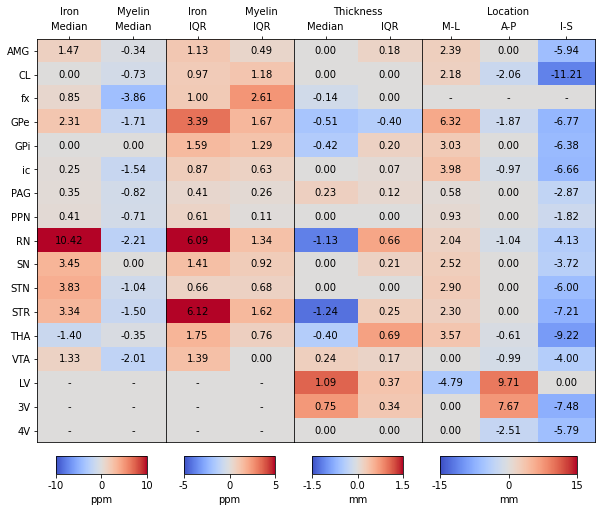

In [8]:
## Grid should be 4 wide, at least 2 high (colorbars below!)
fig = plt.Figure(figsize=(10,8))
width_ratios = np.array([colorbar_grid_offset, 1, colorbar_grid_offset, 
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1.5, colorbar_grid_offset])
width_ratios /= width_ratios.sum()
#width_ratios
gs = plt.GridSpec(3, width_ratios.shape[0], figure=fig, 
                  width_ratios=width_ratios, hspace=0.1, wspace=0,
                  height_ratios=[0.1, 1, .05])

ax = []
for c, (column, (max_value, column_ilocs, label)) in enumerate(plot_dict.items()):
    c = c*3+1
    ax.append(fig.add_subplot(gs[:2,(c-1):(c+2)]))

    this_table = final_table_absolute.iloc[:,column_ilocs]
    color_table_rgb = get_cell_colors(this_table, cmap='coolwarm', max_value=max_value)

    # combine in plot of table
    ax[-1].imshow(color_table_rgb, aspect='auto')
    for i in range(len(this_table)):   # rows
        for j in range(len(this_table.columns)):
            if column == 'location' and i == 2:  # FX location should be '-'
                ax[-1].text(j, i, '-',
                        ha="center", va="center", color='black')
            elif column in ['medians', 'IQRs'] and ('LV' in this_table.index.values[i] or '3V' in this_table.index.values[i] or '4V' in this_table.index.values[i]):
                ax[-1].text(j, i, '-',
                        ha="center", va="center", color='black')
            else:
                ax[-1].text(j, i, '{:.2f}'.format(this_table.values[i, j]),
                        ha="center", va="center", color='black')
    if c > 3:
        ax[-1].set_yticks([])
    else:
        ax[-1].set_yticks(ticks=np.arange(this_table.shape[0]))
        ax[-1].set_yticklabels([x for x in this_table.index.values if x in pretty_names_map.keys()])
#         ax[-1].set_yticklabels([pretty_names_map[x] for x in this_table.index.values if x in pretty_names_map.keys()])
        
    ax[-1].set_xticks(ticks=np.arange(this_table.shape[1]))
    ax[-1].set_xticklabels([title_label_map[x[-1]] for x in this_table.columns])
    ax[-1].xaxis.tick_top()
    
    cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,c]), truncation_limits=(-max_value,max_value), 
                                vmin=-max_value, vmax=max_value, nb_ticks=3,
                                offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
                                format='%.1f' if max_value == 1.5 else '%d',
                                orientation='horizontal', label=label)
# def highlight_cell(x,y, ax=None, **kwargs):
#     rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=True, **kwargs)
#     ax = ax or plt.gca()
#     ax.add_patch(rect)
#     return rect
# highlight_cell(0,2,ax[-1], color='grey')
# highlight_cell(1,2,ax[-1], color='grey')
# highlight_cell(2,2,ax[-1], color='grey')

ax[0].text(0, -1.5, 'Iron', ha='center')
ax[1].text(0, -1.5, 'Iron', ha='center')
ax[0].text(1, -1.5, 'Myelin', ha='center')
ax[1].text(1, -1.5, 'Myelin', ha='center')
ax[2].text(0.5, -1.5, 'Thickness', ha='center')
ax[3].text(1, -1.5, 'Location', ha='center')

fig.savefig('../figures/figure3-v5.pdf', bbox_inches='tight')

fig

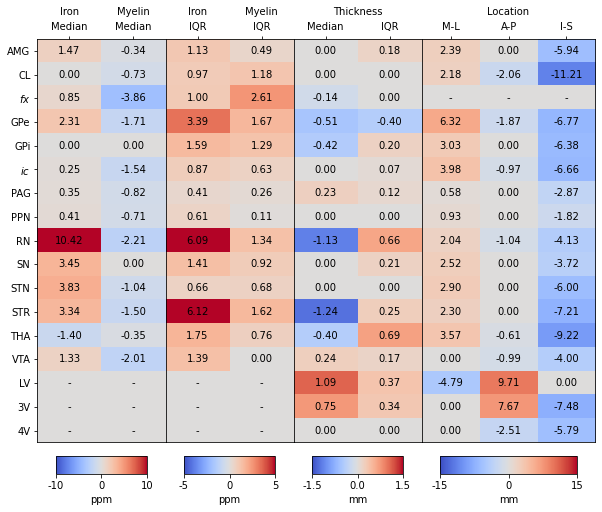

In [22]:
## Grid should be 4 wide, at least 2 high (colorbars below!)
fig = plt.Figure(figsize=(10,8))
width_ratios = np.array([colorbar_grid_offset, 1, colorbar_grid_offset, 
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1.5, colorbar_grid_offset])
width_ratios /= width_ratios.sum()
#width_ratios
gs = plt.GridSpec(3, width_ratios.shape[0], figure=fig, 
                  width_ratios=width_ratios, hspace=0.1, wspace=0,
                  height_ratios=[0.1, 1, .05])

ax = []
for c, (column, (max_value, column_ilocs, label)) in enumerate(plot_dict.items()):
    c = c*3+1
    ax.append(fig.add_subplot(gs[:2,(c-1):(c+2)]))

    this_table = final_table_absolute.iloc[:,column_ilocs]
    color_table_rgb = get_cell_colors(this_table, cmap='coolwarm', max_value=max_value)

    # combine in plot of table
    ax[-1].imshow(color_table_rgb, aspect='auto')
    for i in range(len(this_table)):   # rows
        for j in range(len(this_table.columns)):
            if column == 'location' and i == 2:  # FX location should be '-'
                ax[-1].text(j, i, '-',
                        ha="center", va="center", color='black')
            elif column in ['medians', 'IQRs'] and ('LV' in this_table.index.values[i] or '3V' in this_table.index.values[i] or '4V' in this_table.index.values[i]):
                ax[-1].text(j, i, '-',
                        ha="center", va="center", color='black')
            else:
                ax[-1].text(j, i, '{:.2f}'.format(this_table.values[i, j]),
                        ha="center", va="center", color='black')
    if c > 3:
        ax[-1].set_yticks([])
    else:
        ax[-1].set_yticks(ticks=np.arange(this_table.shape[0]))
        ax[-1].set_yticklabels(['$'+x+'$' if x in ['fx', 'ic'] else x for x in this_table.index.values if x in pretty_names_map.keys()])#[x for x in this_table.index.values if x in pretty_names_map.keys()])
#         ax[-1].set_yticklabels([pretty_names_map[x] for x in this_table.index.values if x in pretty_names_map.keys()])
        
    ax[-1].set_xticks(ticks=np.arange(this_table.shape[1]))
    ax[-1].set_xticklabels([title_label_map[x[-1]] for x in this_table.columns])
    ax[-1].xaxis.tick_top()
    
    cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,c]), truncation_limits=(-max_value,max_value), 
                                vmin=-max_value, vmax=max_value, nb_ticks=3,
                                offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
                                format='%.1f' if max_value == 1.5 else '%d',
                                orientation='horizontal', label=label)
# def highlight_cell(x,y, ax=None, **kwargs):
#     rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=True, **kwargs)
#     ax = ax or plt.gca()
#     ax.add_patch(rect)
#     return rect
# highlight_cell(0,2,ax[-1], color='grey')
# highlight_cell(1,2,ax[-1], color='grey')
# highlight_cell(2,2,ax[-1], color='grey')

ax[0].text(0, -1.5, 'Iron', ha='center')
ax[1].text(0, -1.5, 'Iron', ha='center')
ax[0].text(1, -1.5, 'Myelin', ha='center')
ax[1].text(1, -1.5, 'Myelin', ha='center')
ax[2].text(0.5, -1.5, 'Thickness', ha='center')
ax[3].text(1, -1.5, 'Location', ha='center')

fig.savefig('../figures/figure3-v6.pdf', bbox_inches='tight')

fig

## Add changes proportional

In [9]:
plot_dict_absolute = {'medians': [10, [0,2], 'ppm/year'],
                      'IQRs': [5, [1,3], 'ppm/year'],
                      'thickness': [1.5, [4,5], 'mm/year'],
                      'location': [8, [6,7,8], 'mm/year']
                      }

plot_dict_proportional = {'medians': [1, [0,2], ''],
                          'IQRs': [1, [1,3], 'proportion/year'],
                          'thickness': [1, [4,5], '']
                          }


colorbar_grid_offset = 0.2

In [10]:
## Grid should be 4 wide, at least 2 high (colorbars below!)
fig = plt.Figure(figsize=(10,6))
width_ratios = np.array([colorbar_grid_offset, 1, colorbar_grid_offset, 
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1.5, colorbar_grid_offset,
                         0.3,  # whitespace
                         colorbar_grid_offset, 1, colorbar_grid_offset, 
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         ])
width_ratios /= width_ratios.sum()
#width_ratios
gs = plt.GridSpec(3, width_ratios.shape[0], figure=fig, 
                  width_ratios=width_ratios, hspace=0.1, wspace=0,
                  height_ratios=[0.1, 1, .05])

ax = []
for c, (column, (max_value, column_ilocs, label)) in enumerate(plot_dict_absolute.items()):
    c = c*3+1
    ax.append(fig.add_subplot(gs[:2,(c-1):(c+2)]))

    this_table = final_table_absolute.iloc[:,column_ilocs]
    color_table_rgb = get_cell_colors(this_table, cmap='coolwarm', max_value=max_value)

    # combine in plot of table
    ax[-1].imshow(color_table_rgb, aspect='auto')
    for i in range(len(this_table)):
        for j in range(len(this_table.columns)):
            ax[-1].text(j, i, '{:.2f}'.format(this_table.values[i, j]),
                    ha="center", va="center", color='black')
    if c > 3:
        ax[-1].set_yticks([])
    else:
        ax[-1].set_yticks(ticks=np.arange(this_table.shape[0]))
        ax[-1].set_yticklabels([pretty_names_map[x] for x in this_table.index.values if x in pretty_names_map.keys()])
        
    ax[-1].set_xticks(ticks=np.arange(this_table.shape[1]))
    ax[-1].set_xticklabels(['M' if x[-1]=='median' else 'IQR' if x[-1] == 'iqr' else x[1][0].upper() for x in this_table.columns])
    ax[-1].xaxis.tick_top()
    
    cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,c]), truncation_limits=(-max_value,max_value), 
                                vmin=-max_value, vmax=max_value, nb_ticks=3,
                                offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
                                format='%.1f' if max_value == 1.5 else '%d',
                               orientation='horizontal', label=label)
y_offset = -1.7
ax[0].text(0, y_offset, 'Iron', ha='center')
ax[1].text(0, y_offset, 'Iron', ha='center')
ax[0].text(1, y_offset, 'Myelin', ha='center')
ax[1].text(1, y_offset, 'Myelin', ha='center')
#ax[1].text(0.5, -2.1, 'Tissue degradation', ha='center')
ax[2].text(0.5, y_offset, 'Thickness', ha='center')
ax[3].text(1, y_offset, 'Location', ha='center')
#ax[3].text(-0.5, -2.1, 'Atrophy', ha='center')

# 
for c, (column, (max_value, column_ilocs, label)) in enumerate(plot_dict_proportional.items()):
    c = c*3+14 # whitespace
    ax.append(fig.add_subplot(gs[:2,(c-1):(c+2)]))

    this_table = final_table_proportional.iloc[:,column_ilocs]
    color_table_rgb = get_cell_colors(this_table, cmap='coolwarm', max_value=max_value)

    # combine in plot of table
    ax[-1].imshow(color_table_rgb, aspect='auto')
    for i in range(len(this_table)):
        for j in range(len(this_table.columns)):
            ax[-1].text(j, i, '{:.2f}'.format(this_table.values[i, j]),
                    ha="center", va="center", color='black')
    if c > 3:
        ax[-1].set_yticks([])
    else:
        ax[-1].set_yticks(ticks=np.arange(this_table.shape[0]))
        ax[-1].set_yticklabels([pretty_names_map[x] for x in this_table.index.values if x in pretty_names_map.keys()])
        
    ax[-1].set_xticks(ticks=np.arange(this_table.shape[1]))
    ax[-1].set_xticklabels(['M' if x[-1]=='median' else 'IQR' if x[-1] == 'iqr' else x[1][0].upper() for x in this_table.columns])
    ax[-1].xaxis.tick_top()
    
    cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,c]), truncation_limits=(-max_value,max_value), 
                                vmin=-max_value, vmax=max_value, nb_ticks=3,
                                offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
                                format='%.1f' if max_value == 1.5 else '%d',
                                orientation='horizontal', label=label)

ax[4].text(0, y_offset, 'Iron', ha='center')
ax[5].text(0, y_offset, 'Iron', ha='center')
ax[4].text(1, y_offset, 'Myelin', ha='center')
ax[5].text(1, y_offset, 'Myelin', ha='center')
#ax[1].text(0.5, -2.1, 'Tissue degradation', ha='center')
ax[6].text(0.5, y_offset, 'Thickness', ha='center')
# ax[3].text(1, y_offset, 'Location', ha='center')

# ax[3].text(0, -1.5, 'Iron', ha='center')
# ax[4].text(0, -1.5, 'Iron', ha='center')
# ax[3].text(1, -1.5, 'Myelin', ha='center')
# ax[4].text(1, -1.5, 'Myelin', ha='center')
# ax[4].text(0.5, -2.1, 'Tissue degradation', ha='center')
# ax[3].text(0.5, -1.5, 'Thickness', ha='center')
# ax[3].text(1, -1.5, 'Location', ha='center')
# ax[3].text(-0.5, -2.1, 'Atrophy', ha='center')

# fig.savefig('./table_tmp4.pdf', bbox_inches='tight')

fig


NameError: name 'final_table_proportional' is not defined

## Two tables next to each other with two colormaps

In [11]:
cmap1 = plt.get_cmap('coolwarm')

qMRI_table = final_table.iloc[:,:-3]
location_table = final_table.iloc[:,-3:]

def norm(x, x_max=1.5, vmax=256, vmin=0):
    return int(vmax/2 + (x/x_max)*(vmax-vmin)/2)

def get_hex(tsnr, cmap, **kwargs):
    rgb = cmap(norm(tsnr, **kwargs))[:3]   # no alpha
    return matplotlib.colors.rgb2hex(rgb)

color_table_rgb_qMRI = np.empty((qMRI_table.shape[0], qMRI_table.shape[1], 3))
color_table_hex_qMRI = qMRI_table.copy()
for row in range(qMRI_table.shape[0]):
    for col in range(qMRI_table.shape[1]):
        x = get_hex(qMRI_table.iloc[row, col], cmap=cmap1)
        color_table_hex_qMRI.iloc[row, col] = x
        color_table_rgb_qMRI[row, col, :] = cmap1(norm(qMRI_table.iloc[row, col]))[:3]
        
cmap2 = plt.get_cmap('coolwarm')

def norm(x, x_max=6, vmax=256, vmin=0):
    return int(vmax/2 + (x/x_max)*(vmax-vmin)/2)

def get_hex(tsnr, cmap, **kwargs):
    rgb = cmap(norm(tsnr, **kwargs))[:3]   # no alpha
    return matplotlib.colors.rgb2hex(rgb)

color_table_rgb_location = np.empty((location_table.shape[0], location_table.shape[1], 3))
color_table_hex_location = location_table.copy()
for row in range(location_table.shape[0]):
    for col in range(location_table.shape[1]):
        x = get_hex(location_table.iloc[row, col], cmap=cmap2)
        color_table_hex_location.iloc[row, col] = x
        color_table_rgb_location[row, col, :] = cmap2(norm(location_table.iloc[row, col]))[:3]

NameError: name 'final_table' is not defined

In [319]:
from nilearn import plotting
def draw_custom_colorbar(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True,
                         format="%.1f", cmap=plotting.cm.cold_hot, tick_left=True, tick_right=False, is_symmetric=True):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = cmap
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    
    if nb_ticks > 0:
        ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    else:
        ticks = []
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    if is_symmetric:
        norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation='vertical', cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format=format)
    
    if flip:
        colorbar_ax.invert_yaxis()
    if tick_left:
        colorbar_ax.yaxis.tick_left()
    if tick_right:
        colorbar_ax.yaxis.tick_right()

    return colorbar_ax

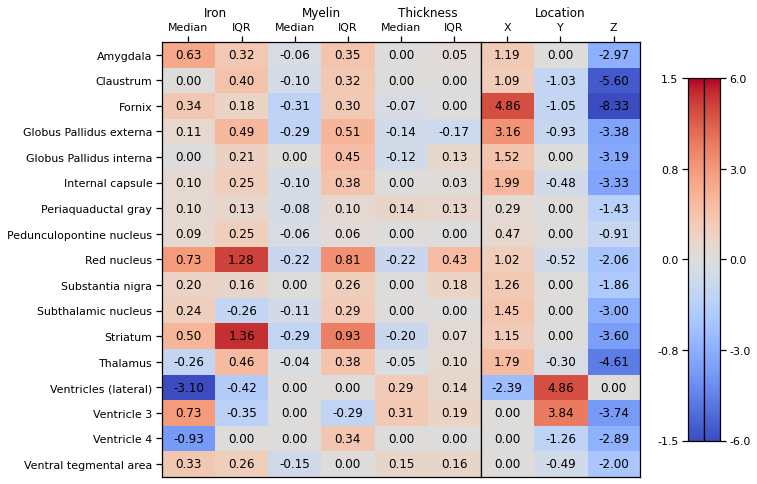

In [346]:
# combine in plot of table
fig = plt.Figure(figsize=(10,8))
width_ratios = np.array([1, 0.5, 0.15, .05, .05])
width_ratios /= width_ratios.sum()
#width_ratios
gs = plt.GridSpec(3, width_ratios.shape[0], figure=fig, 
                  width_ratios=width_ratios, hspace=0, wspace=0,
                  height_ratios=[0.1, 1, .1])

ax = []
ax.append(fig.add_subplot(gs[:,0]))
ax.append(fig.add_subplot(gs[:,1]))
ims = []
for index, (table, color_table) in enumerate(zip([qMRI_table, location_table], [color_table_rgb_qMRI, color_table_rgb_location])):
    if index == 0:
        aspect = 'auto'
    else:
        aspect = 'auto'
    ax_ = ax[index]
    ims.append(ax_.imshow(color_table, aspect=aspect, alpha=1))
    for i in range(len(table)):
        for j in range(len(table.columns)):
            ax_.text(j, i, '{:.2f}'.format(table.values[i, j]),
                       ha="center", va="center", color='black')
    ax_.set_yticks(ticks=np.arange(table.shape[0]))
    ax_.set_xticks(ticks=np.arange(table.shape[1]))
    ax_.set_xticklabels([x[-1].title() if x[-1]=='median' else 'IQR' if x[-1] == 'iqr' else x[1][0].upper() for x in table.columns])
    ax_.set_yticklabels([pretty_names_map[x] for x in table.index.values if x in pretty_names_map.keys()])
    ax_.xaxis.tick_top()

cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[1,3]), truncation_limits=(-1.5,1.5), 
                                vmin=-1.5, vmax=1.5, nb_ticks=5,
                                offset=0, flip=False, cmap=cmap1)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[1,4]), 
                                truncation_limits=(-6,6),
                                vmin=-6, vmax=6, 
                                offset=0,
                                flip=False, tick_left=False, nb_ticks=5, cmap=cmap2)

ax[-1].set_yticklabels(['' for i in ax[-1].get_yticklabels()])
ax[-1].yaxis.set_ticks([])
ax[0].text(0.5, -1.5, 'Iron', ha='center')
ax[0].text(2.5, -1.5, 'Myelin', ha='center')
ax[0].text(4.5, -1.5, 'Thickness', ha='center')
ax[1].text(1, -1.5, 'Location', ha='center')

#fig.savefig('./table_tmp2.pdf', bbox_inches='tight')
fig

## two matrices

## Correlation matrices
1. Across-ROI

ROI              AMG        CL  Cerebellum    Cortex        FX       GPE  \
ROI                                                                        
AMG         1.000000  0.422159    0.857852  0.823663  0.920321  0.668615   
CL          0.422159  1.000000    0.794769  0.680684  0.616124  0.947864   
Cerebellum  0.857852  0.794769    1.000000  0.899624  0.886549  0.902949   
Cortex      0.823663  0.680684    0.899624  1.000000  0.723399  0.827261   
FX          0.920321  0.616124    0.886549  0.723399  1.000000  0.801590   
GPE         0.668615  0.947864    0.902949  0.827261  0.801590  1.000000   
GPI         0.334042  0.768427    0.559043  0.463856  0.529696  0.764760   
IC          0.622174  0.910267    0.820291  0.705642  0.811513  0.968514   
LVENT      -0.826101  0.114932   -0.501800 -0.560843 -0.577264 -0.159703   
PAG         0.370789  0.454534    0.485081  0.119058  0.630027  0.450642   
PPN         0.620096  0.804159    0.905963  0.784585  0.662782  0.802523   
RN          0.736967  0.823354    0.956906  0.788144  0.816093  0.871855   
SN          0.723254  0.589728    0.748967  0.533383  0.856583  0.712880   
STN         0.525638 -0.072814    0.156097  0.140800  0.554561  0.184345   
STR         0.678891  0.932334    0.952354  0.848563  0.774671  0.961287   
THA        -0.006543  0.882438    0.462544  0.340454  0.242252  0.711308   
VENT3       0.235899 -0.712404   -0.216408 -0.231103  0.058391 -0.516415   
VENT4      -0.594140  0.386134   -0.239368 -0.280658 -0.322240  0.155705   
VTA         0.634080  0.221130    0.607325  0.350589  0.651657  0.314075   

ROI              GPI        IC     LVENT       PAG       PPN        RN  \
ROI                                                                      
AMG         0.334042  0.622174 -0.826101  0.370789  0.620096  0.736967   
CL          0.768427  0.910267  0.114932  0.454534  0.804159  0.823354   
Cerebellum  0.559043  0.820291 -0.501800  0.485081  0.905963  0.956906   
Cortex      0.463856  0.705642 -0.560843  0.119058  0.784585  0.788144   
FX          0.529696  0.811513 -0.577264  0.630027  0.662782  0.816093   
GPE         0.764760  0.968514 -0.159703  0.450642  0.802523  0.871855   
GPI         1.000000  0.855989  0.181609  0.148868  0.364962  0.669743   
IC          0.855989  1.000000 -0.074499  0.477775  0.656931  0.813128   
LVENT       0.181609 -0.074499  1.000000 -0.088225 -0.312302 -0.349256   
PAG         0.148868  0.477775 -0.088225  1.000000  0.524288  0.479272   
PPN         0.364962  0.656931 -0.312302  0.524288  1.000000  0.885998   
RN          0.669743  0.813128 -0.349256  0.479272  0.885998  1.000000   
SN          0.781859  0.793802 -0.340419  0.451720  0.481346  0.817716   
STN         0.273040  0.343556 -0.419462  0.168588 -0.243678  0.051019   
STR         0.712164  0.891283 -0.226236  0.436457  0.905381  0.959454   
THA         0.791473  0.715907  0.519506  0.247282  0.541288  0.595972   
VENT3      -0.694250 -0.512203 -0.651134  0.102237 -0.315964 -0.345365   
VENT4       0.499449  0.253454  0.933182 -0.061523 -0.145599 -0.097245   
VTA        -0.150296  0.230363 -0.609905  0.770990  0.647803  0.549922   

ROI               SN       STN       STR       THA     VENT3     VENT4  \
ROI                                                                      
AMG         0.723254  0.525638  0.678891 -0.006543  0.235899 -0.594140   
CL          0.589728 -0.072814  0.932334  0.882438 -0.712404  0.386134   
Cerebellum  0.748967  0.156097  0.952354  0.462544 -0.216408 -0.239368   
Cortex      0.533383  0.140800  0.848563  0.340454 -0.231103 -0.280658   
FX          0.856583  0.554561  0.774671  0.242252  0.058391 -0.322240   
GPE         0.712880  0.184345  0.961287  0.711308 -0.516415  0.155705   
GPI         0.781859  0.273040  0.712164  0.791473 -0.694250  0.499449   
IC          0.793802  0.343556  0.891283  0.715907 -0.512203  0.253454   
LVENT      -0.340419 -0.419462 -0.226236  0.519506 -0.651134  0.933182   
PAG         0.451720  0.168588  0.

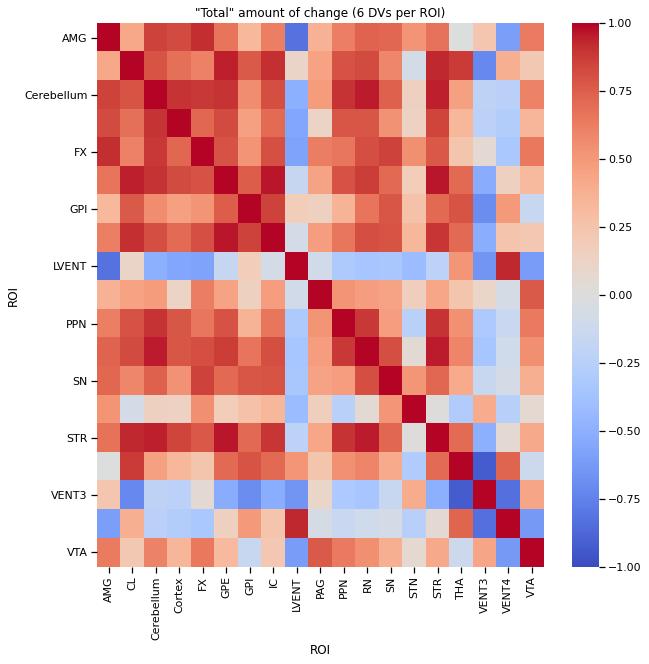

In [225]:
tmp = winning_model_df.loc[winning_model_df.qMRI.isin(['iron', 'myelin', 'thickness'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['ivs', 'mean_derivative']].copy()

corrmatrix = tmp.pivot_table(values='mean_derivative', columns=['Statistic', 'qMRI'], index=['ROI']).T.corr() #.abs()
display(corrmatrix)
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.gcf().set_size_inches(10,10)
plt.title('"Total" amount of change (6 DVs per ROI)')
plt.gcf().savefig('../figures/corrmatrix_between-ROIs_dv-total-change.pdf')

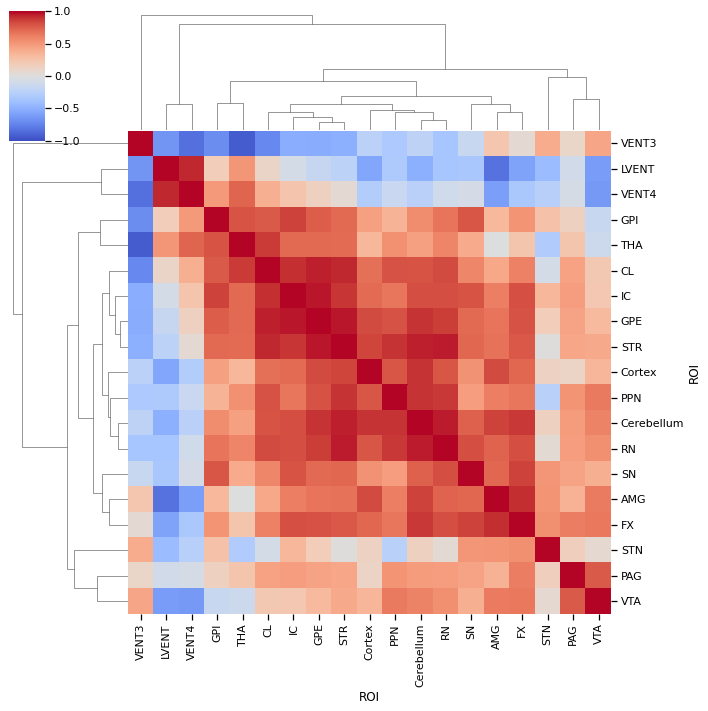

In [135]:
sns.clustermap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1)

## Correlation matrix 2
2. Across-metric

qMRI                     iron              myelin           thickness  \
Statistic                 iqr    median       iqr    median       iqr   
qMRI      Statistic                                                     
iron      iqr        1.000000  0.452535  0.835390 -0.606475  0.165122   
          median     0.452535  1.000000  0.236008 -0.379680  0.017385   
myelin    iqr        0.835390  0.236008  1.000000 -0.533863  0.097349   
          median    -0.606475 -0.379680 -0.533863  1.000000  0.145824   
thickness iqr        0.165122  0.017385  0.097349  0.145824  1.000000   
          median    -0.739522 -0.424829 -0.789086  0.521187  0.289090   

qMRI                           
Statistic              median  
qMRI      Statistic            
iron      iqr       -0.739522  
          median    -0.424829  
myelin    iqr       -0.789086  
          median     0.521187  
thickness iqr        0.289090  
          median     1.000000

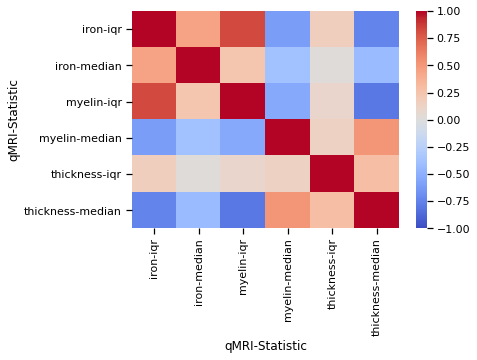

In [228]:
tmp = winning_model_df.loc[winning_model_df.qMRI.isin(['iron', 'myelin', 'thickness'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['ivs', 'mean_derivative']].copy()

corrmatrix = tmp.pivot_table(values='mean_derivative', columns=['qMRI', 'Statistic'], index=['ROI']).corr() #.abs()
display(corrmatrix)
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.gcf().savefig('../figures/corrmatrix_between-dvs_dv-ROI.pdf', bbox_inches='tight')

## Correlation matrix per ROI
Ignore age-related change, just inspect the 6 dep vars per ROI

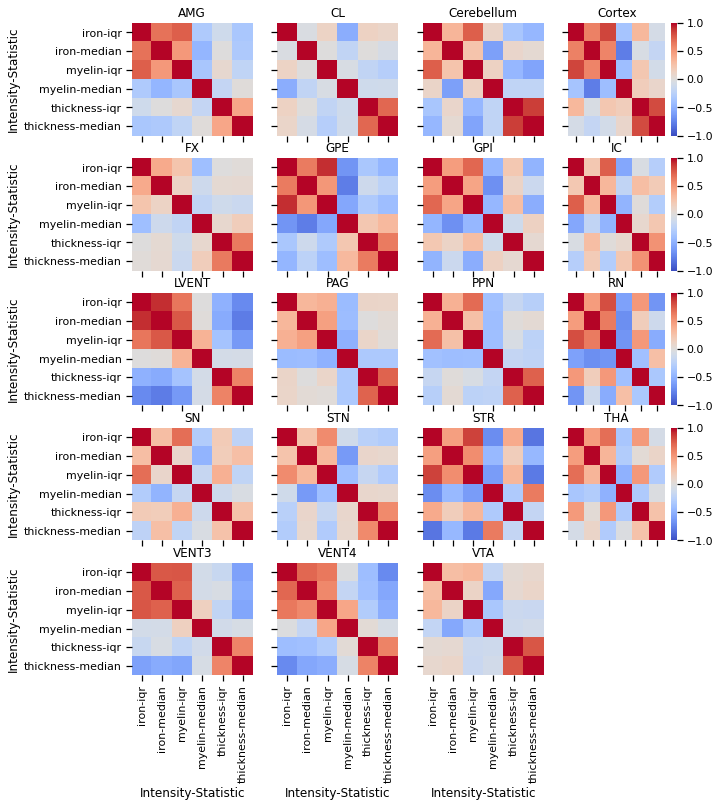

In [219]:
all_corrs = []

f, ax = plt.subplots(5, 4, figsize=(10,12), sharey=True, sharex=True)
ax_ = ax.ravel()
for i, ROI in enumerate(qMRI_data_collapsed.ROI2.unique()):
    tmp2 = qMRI_data_collapsed.loc[(qMRI_data_collapsed['ROI2'] == ROI) & (qMRI_data_collapsed['Intensity'].isin(['iron', 'myelin', 'thickness']))]
    corrmatrix = tmp2.pivot_table(values='Value', index=['Segmentation'], columns=['Intensity', 'Statistic']).corr()
#    display(corrmatrix)
    cbar = True if (i+1) % 4 == 0 else False
    sns.heatmap(corrmatrix, ax=ax_[i], vmin=-1, vmax=1, cbar=cbar, cmap='coolwarm')
    ax_[i].set_title(ROI)
    
    ## extract correlations
    corrmatrix.columns = corrmatrix.columns.map('_'.join)
    corrmatrix.index = corrmatrix.index.map('_'.join)
    tmp = corrmatrix.where(np.triu(np.ones(corrmatrix.shape),k=1).astype(np.bool)).stack().reset_index()
    tmp = tmp.rename(columns={0: ROI})
    if i == 0:
        all_corrs = tmp
    else:
        all_corrs = pd.merge(all_corrs, tmp)

for row in np.arange(0, ax.shape[0]):
    for col in np.arange(0, ax.shape[1]):
        if col > 0:
            ax[row, col].set_ylabel('')
        if row < ax.shape[0]-1:
            ax[row, col].set_xlabel('')
            
ax_[-1].set_axis_off()
plt.gcf().savefig('../figures/correlations_between_dvs_by_roi.pdf', bbox_inches='tight')

In [220]:
all_corrs.corr()

AMG        CL  Cerebellum    Cortex        FX       GPE  \
AMG         1.000000  0.462552    0.716766  0.905107  0.723614  0.908165   
CL          0.462552  1.000000    0.564855  0.623941  0.820883  0.540847   
Cerebellum  0.716766  0.564855    1.000000  0.647067  0.627259  0.726752   
Cortex      0.905107  0.623941    0.647067  1.000000  0.769798  0.891985   
FX          0.723614  0.820883    0.627259  0.769798  1.000000  0.834052   
GPE         0.908165  0.540847    0.726752  0.891985  0.834052  1.000000   
GPI         0.878578  0.362649    0.549009  0.856259  0.588708  0.819635   
IC          0.794767  0.615701    0.633239  0.785789  0.814423  0.878194   
LVENT       0.726862  0.289896    0.699362  0.526082  0.485580  0.654387   
PAG         0.769841  0.715214    0.562080  0.843348  0.750622  0.674060   
PPN         0.891274  0.690548    0.815273  0.875261  0.831630  0.866044   
RN          0.756526  0.178248    0.331519  0.708610  0.394205  0.647013   
SN          0.753127  0.460175    0.596238  0.783746  0.564209  0.693126   
STN         0.837474  0.539489    0.844758  0.851767  0.759443  0.919178   
STR         0.764854  0.244387    0.367399  0.682031  0.480378  0.704785   
THA         0.777164  0.441339    0.406657  0.796596  0.559783  0.630808   
VENT3       0.854700  0.409960    0.786719  0.673855  0.589413  0.766227   
VENT4       0.740294  0.334292    0.774802  0.572160  0.510299  0.698844   
VTA         0.720372  0.795889    0.751527  0.842229  0.844194  0.748145   

                 GPI        IC     LVENT       PAG       PPN        RN  \
AMG         0.878578  0.794767  0.726862  0.769841  0.891274  0.756526   
CL          0.362649  0.615701  0.289896  0.715214  0.690548  0.178248   
Cerebellum  0.549009  0.633239  0.699362  0.562080  0.815273  0.331519   
Cortex      0.856259  0.785789  0.526082  0.843348  0.875261  0.708610   
FX          0.588708  0.814423  0.485580  0.750622  0.831630  0.394205   
GPE         0.819635  0.878194  0.654387  0.674060  0.866044  0.647013   
GPI         1.000000  0.810852  0.473627  0.639367  0.750909  0.951145   
IC          0.810852  1.000000  0.402655  0.707417  0.877586  0.694475   
LVENT       0.473627  0.402655  1.000000  0.354717  0.575766  0.323670   
PAG         0.639367  0.707417  0.354717  1.000000  0.878818  0.525214   
PPN         0.750909  0.877586  0.575766  0.878818  1.000000  0.576310   
RN          0.951145  0.694475  0.323670  0.525214  0.576310  1.000000   
SN          0.880025  0.791705  0.264297  0.685801  0.802104  0.807215   
STN         0.759345  0.851995  0.543378  0.706774  0.895717  0.566900   
STR         0.924439  0.737083  0.451754  0.434943  0.563939  0.947351   
THA         0.886907  0.728237  0.298775  0.769334  0.743011  0.880497   
VENT3       0.670845  0.603423  0.951725  0.513529  0.729047  0.528000   
VENT4       0.511682  0.447083  0.982369  0.361182  0.619981  0.337106   
VTA         0.598574  0.724807  0.356223  0.879479  0.886289  0.399019   

                  SN       STN       STR       THA     VENT3     VENT4  \
AMG         0.753127  0.837474  0.764854  0.777164  0.854700  0.740294   
CL          0.460175  0.539489  0.244387  0.441339  0.409960  0.334292   
Cerebellum  0.596238  0.844758  0.367399  0.406657  0.786719  0.774802   
Cortex      0.783746  0.851767  0.682031  0.796596  0.673855  0.572160   
FX          0.564209  0.759443  0.480378  0.559783  0.589413  0.510299   
GPE         0.693126  0.919178  0.704785  0.630808  0.766227  0.698844   
GPI         0.880025  0.759345  0.924439  0.886907  0.670845  0.511682   
IC          0.791705  0.851995  0.737083  0.728237  0.603423  0.447083   
LVENT       0.264297  0.543378  0.451754  0.298775  0.951725  0.982369   
PAG         0.685801  0.706774  0.434943  0.769334  0.513529  0.361182   
PPN         0.802104  0.895717  0.563939  0.743011  0.729047  0.619981   
RN          0.807215  0.566900  0.947351  0.880497  0.528000  0.337106   
SN          1.000000  0.727746  0.712910  0.876076  0

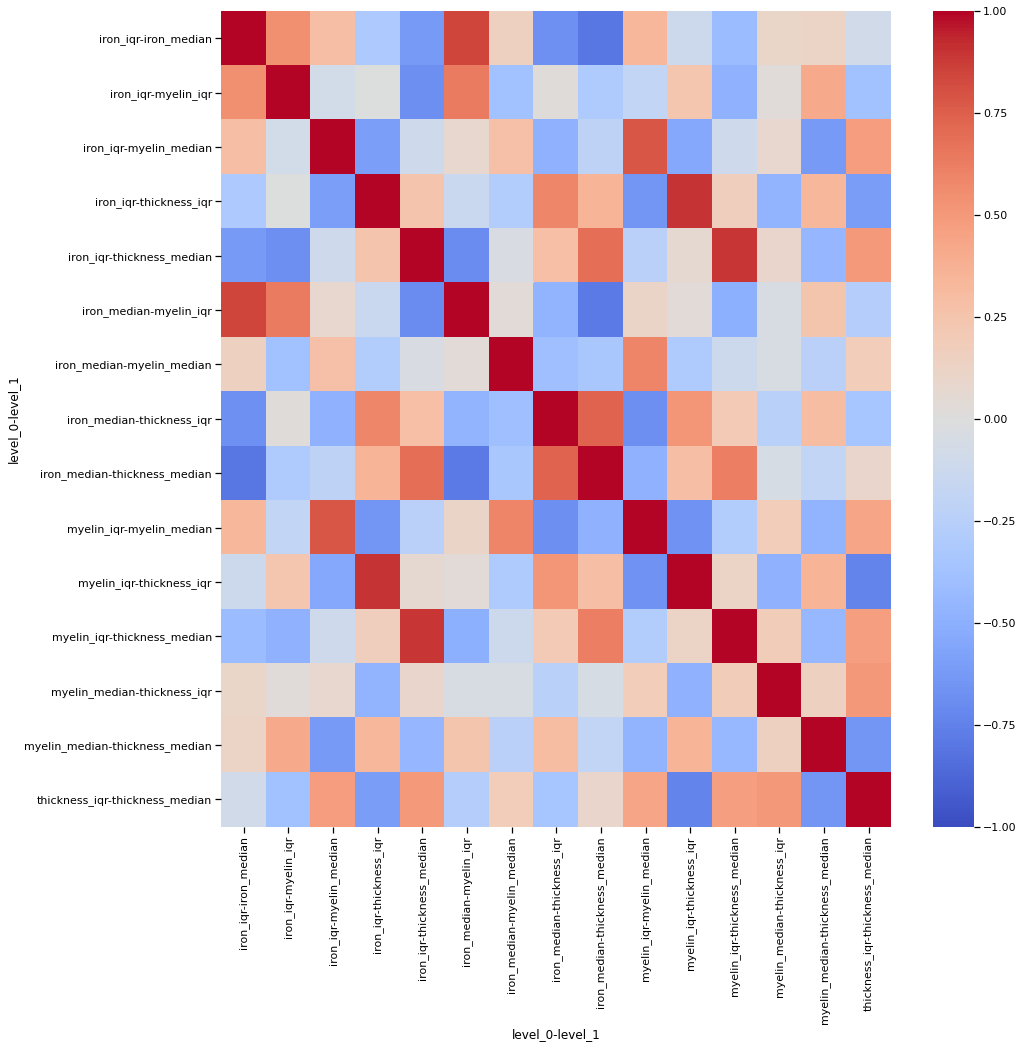

In [217]:
# sns.heatmap(all_corrs.set_index(['level_0', 'level_1']).T.corr(), cmap='coolwarm', vmin=-1, vmax=1)
# plt.gcf().set_size_inches(15,15)


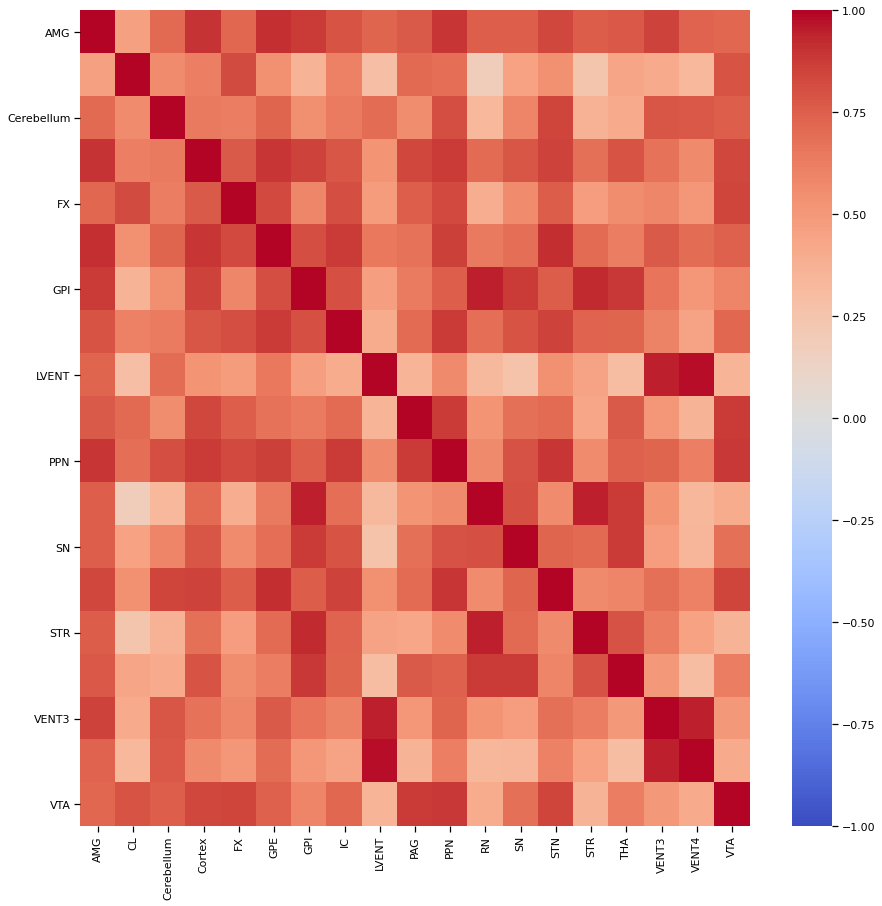

In [221]:
sns.heatmap(all_corrs.set_index(['level_0', 'level_1']).corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.gcf().set_size_inches(15,15)
plt.gcf().savefig('../figures/correlations_between_dvs_by_roi_across_roi.pdf', bbox_inches='tight')

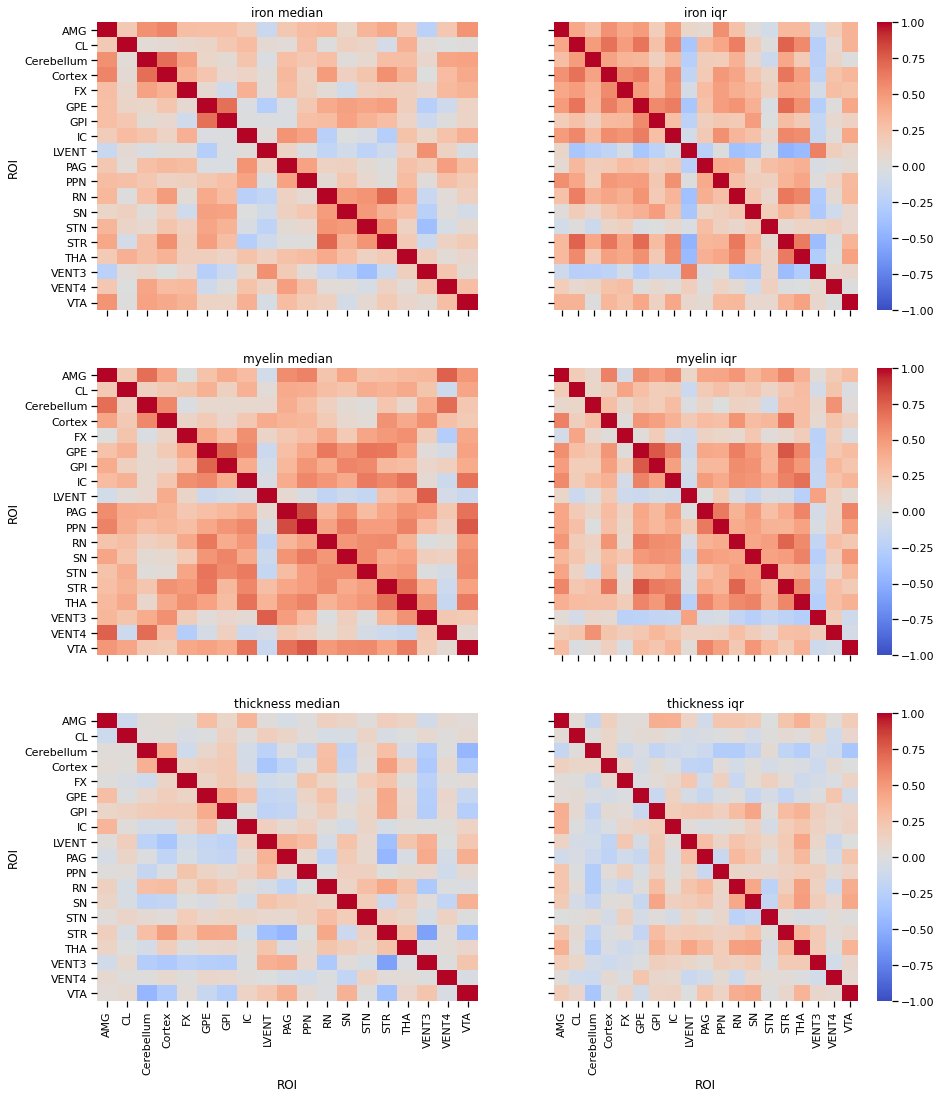

In [222]:
f, ax = plt.subplots(3, 2, figsize=(15,18), sharey=True, sharex=True)
ax_ = ax.ravel()
plot_n = 0
for i, qMRI in enumerate(['iron', 'myelin', 'thickness']):
    for ii, statistic in enumerate(['median', 'iqr']):
        tmp2 = qMRI_data_collapsed.loc[(qMRI_data_collapsed['Intensity'].isin([qMRI])) & (qMRI_data_collapsed['Statistic'] == statistic)]
        corrmatrix = tmp2.pivot_table(values='Value', index=['Segmentation'], columns=['ROI']).corr()#.abs()
    #    display(corrmatrix)
        cbar = True if (plot_n+1) % 2 == 0 else False
        sns.heatmap(corrmatrix, ax=ax_[plot_n], vmin=-1, vmax=1, cbar=cbar, cmap='coolwarm')
        ax_[plot_n].set_title(qMRI + ' ' + statistic)
        plot_n += 1

for row in np.arange(0, ax.shape[0]):
    for col in np.arange(0, ax.shape[1]):
        if col > 0:
            ax[row, col].set_ylabel('')
        if row < ax.shape[0]-1:
            ax[row, col].set_xlabel('')
            
#ax_[-1].set_axis_off()
plt.gcf().savefig('../figures/correlations_between_rois_by_dvs.pdf', bbox_inches='tight')

<AxesSubplot:xlabel='ROI', ylabel='ROI'>

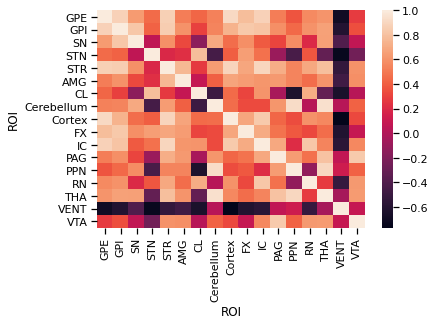

In [159]:
## BG vs rest?
tmp2 = tmp.pivot_table(values='mean_derivative', columns=['Statistic', 'qMRI'], index=['ROI'])
tmp2_cm = tmp2.loc[['GPE', 'GPI', 'SN', 'STN', 'STR', 'AMG', 'CL', 'Cerebellum', 'Cortex', 'FX', 'IC', 'PAG', 'PPN', 'RN', 'THA', 'VENT', 'VTA']].T.corr()
sns.heatmap(tmp2_cm)

In [151]:
tmp2.index

Index(['AMG', 'CL', 'Cerebellum', 'Cortex', 'FX', 'GPE', 'GPI', 'IC', 'PAG',
       'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VENT', 'VTA'],
      dtype='object', name='ROI')

In [166]:
tmp = tmp.reset_index()

In [167]:
summary_table = tmp.loc[tmp.qMRI.isin(['r1hz', 'r2hz', 'qsm', 'thickness'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['ivs', 'mean_derivative']]#.to_csv('./model_comparison_overview.csv')

summary_table.reset_index()[['qMRI', 'ROI', 'Statistic', 'mean_derivative']].pivot_table(index='ROI', columns=['Statistic', 'qMRI']).round(3)

mean_derivative                                                 \
Statistic              iqr                          median                  
qMRI                   qsm   r1hz    r2hz thickness    qsm   r1hz    r2hz   
ROI                                                                         
AMG                  0.000  0.003   5.244     0.180  0.000  0.025   5.753   
CL                   0.006  0.044   3.015     0.000 -0.005  0.000   4.629   
Cerebellum           0.006  0.009   5.399    -0.212  0.000 -0.008   2.614   
Cortex               0.004  0.020   7.400    -1.119  0.000  0.009   4.014   
FX                   0.000  0.118   6.638     0.000  0.000 -0.117   2.733   
GPE                  0.014  0.028  10.376    -0.401  0.000 -0.089  13.170   
GPI                  0.008  0.019   7.256     0.205  0.000 -0.079  11.716   
IC                   0.007  0.011   4.117     0.065 -0.003 -0.050   2.727   
PAG                  0.003  0.006   1.996     0.117  0.000 -0.011   1.826   
PPN                  0.000  0.000   2.437     0.000 -0.002 -0.009   1.285   
RN                   0.026  0.005  15.420     0.656  0.037 -0.094  24.266   
SN                   0.008  0.020   4.341     0.208  0.000  0.069  12.316   
STN                  0.000  0.018   5.244     0.000  0.016 -0.066   9.213   
STR                  0.018  0.028  15.796     0.253 -0.000  0.043  11.062   
THA                  0.009  0.006   5.861     0.685 -0.003 -0.048   4.153   
VENT                -0.006 -0.051  -8.135     0.100 -0.002 -0.064  -4.322   
VTA                  0.009 -0.020   4.774     0.170  0.000 -0.069   4.378   

                      
Statistic             
qMRI       thickness  
ROI                   
AMG            0.000  
CL             0.000  
Cerebellum    -0.688  
Cortex        -1.484  
FX            -0.139  
GPE           -0.511  
GPI           -0.424  
IC             0.000  
PAG            0.231  
PPN            0.000  
RN            -1.130  
SN             0.000  
STN            0.000  
STR           -1.241  
THA           -0.403  
VENT           0.540  
VTA            0.242

In [103]:
summary_table

ivs  mean_derivative
Statistic ROI  qMRI                                        
iqr       AMG  qsm                       1     4.440892e-16
               r1hz               Age2:sex     1.655811e-01
               r2hz                   Age2     1.488104e+02
               thickness          Age2:sex     1.099322e+01
          CL   qsm                     Age     2.008520e-01
...                                    ...              ...
median    VENT thickness               Age     1.823709e+01
          VTA  qsm                       1     1.110223e-16
               r1hz       Age + Age2 + sex     1.982733e+00
               r2hz                    Age     1.478332e+02
               thickness         Age + sex     1.147219e+01

[136 rows x 2 columns]

mean_derivative              
Statistic              iqr        median
qMRI             thickness     thickness
ROI                                     
AMG           1.099322e+01  1.136868e-13
CL           -2.131628e-14  2.842171e-14
Cerebellum   -4.462854e+00 -1.446457e+01
Cortex        1.439893e+01  1.886013e+01
FX           -2.842171e-14  5.934819e+00
GPE           2.177056e+01  2.743558e+01
GPI           6.936037e+00  1.432675e+01
IC            5.779996e+00  0.000000e+00
PAG           3.944377e+00  1.012656e+01
PPN           1.421085e-14  0.000000e+00
RN            1.861564e+01  3.815297e+01
SN            7.035794e+00  3.120140e+00
STN           1.421085e-14 -1.421085e-14
STR           8.555868e+00  4.189675e+01
THA           3.564187e+01  1.984191e+01
VENT          6.128075e+00  1.823709e+01
VTA           5.725554e+00  1.147219e+01

## Summary table

In [131]:
winning_model_df2 = winning_model_df.copy()
age_range = np.array([20,75])
predict_df = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'Age3': age_range**3, 'Age4': age_range**4, 'sex': 0.5})

winning_model_df2['prediction_20yo'] = winning_model_df2['result'].apply(lambda x: x.predict(predict_df).loc[0])
winning_model_df2['prediction_75yo'] = winning_model_df2['result'].apply(lambda x: x.predict(predict_df).loc[1])
# winning_model_df2['increase_pct'] = (winning_model_df2['prediction_75yo']-winning_model_df2['prediction_20yo'])/(winning_model_df2['prediction_75yo']+winning_model_df2['prediction_20yo'])
winning_model_df2['increase_pct'] = winning_model_df2['prediction_75yo']/winning_model_df2['prediction_20yo']

# save table
summary_table = winning_model_df2.loc[winning_model_df2.qMRI.isin(['iron', 'myelin', 'thickness'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['ivs', 'prediction_20yo', 'prediction_75yo', 'increase_pct']]#.to_csv('./model_comparison_overview.csv')
#summary_table.to_csv('./model_comparison_overview.csv')

In [80]:
winning_model_df2 = winning_model_df.copy()
age_range = np.arange(19,75)
predict_df = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'Age3': age_range**3, 'Age4': age_range**4, 'sex': 0})

# winning_model_df2['prediction_20yo'] = winning_model_df2['result'].apply(lambda x: x.predict(predict_df))
# winning_model_df2['prediction_75yo'] = winning_model_df2['result'].apply(lambda x: x.predict(predict_df).loc[1])
# winning_model_df2['increase_pct_symm'] = (winning_model_df2['prediction_75yo']-winning_model_df2['prediction_20yo'])/(winning_model_df2['prediction_75yo']+winning_model_df2['prediction_20yo'])
# winning_model_df2['increase_pct'] = winning_model_df2['prediction_75yo']/winning_model_df2['prediction_20yo']

# # save table
# summary_table = winning_model_df2.loc[winning_model_df2.qMRI.isin(['iron', 'myelin', 'thickness'])].sort_values(['Statistic', 'ROI', 'qMRI']).set_index(['Statistic', 'ROI', 'qMRI'])[['ivs', 'prediction_20yo', 'prediction_75yo', 'increase_pct', 'increase_pct_symm']]#.to_csv('./model_comparison_overview.csv')
# #summary_table.to_csv('./model_comparison_overview.csv')

In [142]:
qMRI_data

Measure Segmentation   Age Sexe         ROI        ROI2  \
0          IQR_intensity      sub-000  22.0    f       AMG L         AMG   
1          IQR_intensity      sub-000  22.0    f       AMG R         AMG   
2          IQR_intensity      sub-000  22.0    f        CL L          CL   
3          IQR_intensity      sub-000  22.0    f        CL R          CL   
4          IQR_intensity      sub-000  22.0    f  Cerebellum  Cerebellum   
...                  ...          ...   ...  ...         ...         ...   
124877  Median_intensity      sub-109  23.0    f      VENT 4        VENT   
124878  Median_intensity      sub-109  23.0    f      VENT L        VENT   
124879  Median_intensity      sub-109  23.0    f      VENT R        VENT   
124880  Median_intensity      sub-109  23.0    f       VTA L         VTA   
124881  Median_intensity      sub-109  23.0    f       VTA R         VTA   

       hemisphere        icv  Intensity     Value Statistic  
0               L  1408505.6       iron  2.810272       iqr  
1               R  1408505.6       iron  3.357533       iqr  
2               L  1408505.6       iron  2.503479       iqr  
3               R  1408505.6       iron  2.038232       iqr  
4               L  1408505.6       iron  5.302089       iqr  
...           ...        ...        ...       ...       ...  
124877          4  1363826.2  thickness  5.225818    median  
124878          L  1363826.2  thickness  3.743737    median  
124879          R  1363826.2  thickness  4.399815    median  
124880          L  1363826.2  thickness  1.400000    median  
124881          R  1363826.2  thickness  1.282000    median  

[42840 rows x 11 columns]

In [159]:
tmp2

Statistic Segmentation   Age Sexe         ROI        ROI2       iqr            \
Intensity                                                      iron    myelin   
0              sub-000  22.0    f       AMG L         AMG  2.810272  1.655631   
1              sub-000  22.0    f       AMG R         AMG  3.357533  2.277326   
2              sub-000  22.0    f        CL L          CL  2.503479  3.032878   
3              sub-000  22.0    f        CL R          CL  2.038232  3.495015   
4              sub-000  22.0    f  Cerebellum  Cerebellum  5.302089  5.426502   
...                ...   ...  ...         ...         ...       ...       ...   
3565           sub-109  23.0    f      VENT 4        VENT  2.187876  1.001831   
3566           sub-109  23.0    f      VENT L        VENT  5.227677  2.939738   
3567           sub-109  23.0    f      VENT R        VENT  3.758741  1.786715   
3568           sub-109  23.0    f       VTA L         VTA  3.532859  3.628473   
3569           sub-109  23.0    f       VTA R         VTA  4.044608  3.361718   

Statistic              median                       
Intensity thickness      iron     myelin thickness  
0          3.508986  1.119582   6.555421  4.510455  
1          3.742885  1.216937   7.470468  4.554864  
2          0.629818  3.306220  10.914494  1.400000  
3          1.189013  2.880328  10.169862  1.400000  
4          4.097502  3.975790   3.715492  7.228459  
...             ...       ...        ...       ...  
3565       3.102171 -2.045718   1.280044  5.225818  
3566       2.369199  1.105959   3.117882  3.743737  
3567       2.902813 -0.543515   2.332390  4.399815  
3568       1.035591  2.885817  15.912046  1.400000  
3569       0.645177  3.944471  15.494354  1.282000  

[3570 rows x 11 columns]

In [160]:
tmp2[['iqr', 'median']].set_index(['ROI2'])

KeyError: "None of ['ROI2'] are in the columns"

<AxesSubplot:>

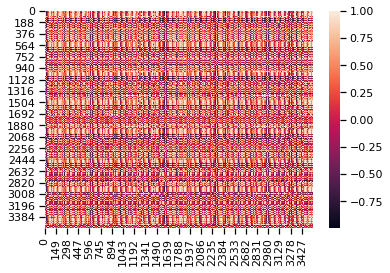

In [156]:
tmp2 = qMRI_data.loc[qMRI_data.Intensity.isin(['iron', 'thickness', 'myelin'])].pivot_table(values='Value', columns=['Statistic', 'Intensity'], index=['Segmentation', 'Age', 'Sexe', 'ROI', 'ROI2']).reset_index()
sns.heatmap(tmp2[['iqr', 'median']].T.corr())

In [105]:
tmp = winning_model_df2.loc[winning_model_df2.qMRI.isin(['iron', 'myelin', 'thickness'])].apply(lambda x: x.result.predict(predict_df), axis=1)
tmp[['ROI', 'qMRI', 'Statistic']] = winning_model_df2[['ROI', 'qMRI', 'Statistic']].copy()

In [128]:
tmp.set_index(['ROI', 'qMRI', 'Statistic']).T['GPI'].corr().round(2)

qMRI                  iron       myelin       thickness      
Statistic           median   iqr median   iqr    median   iqr
qMRI      Statistic                                          
iron      median       NaN   NaN    NaN   NaN       NaN   NaN
          iqr          NaN  1.00    0.0  0.99     -0.99  0.99
myelin    median       NaN  0.00    1.0 -0.00     -0.00  0.00
          iqr          NaN  0.99   -0.0  1.00     -1.00  1.00
thickness median       NaN -0.99   -0.0 -1.00      1.00 -1.00
          iqr          NaN  0.99    0.0  1.00     -1.00  1.00

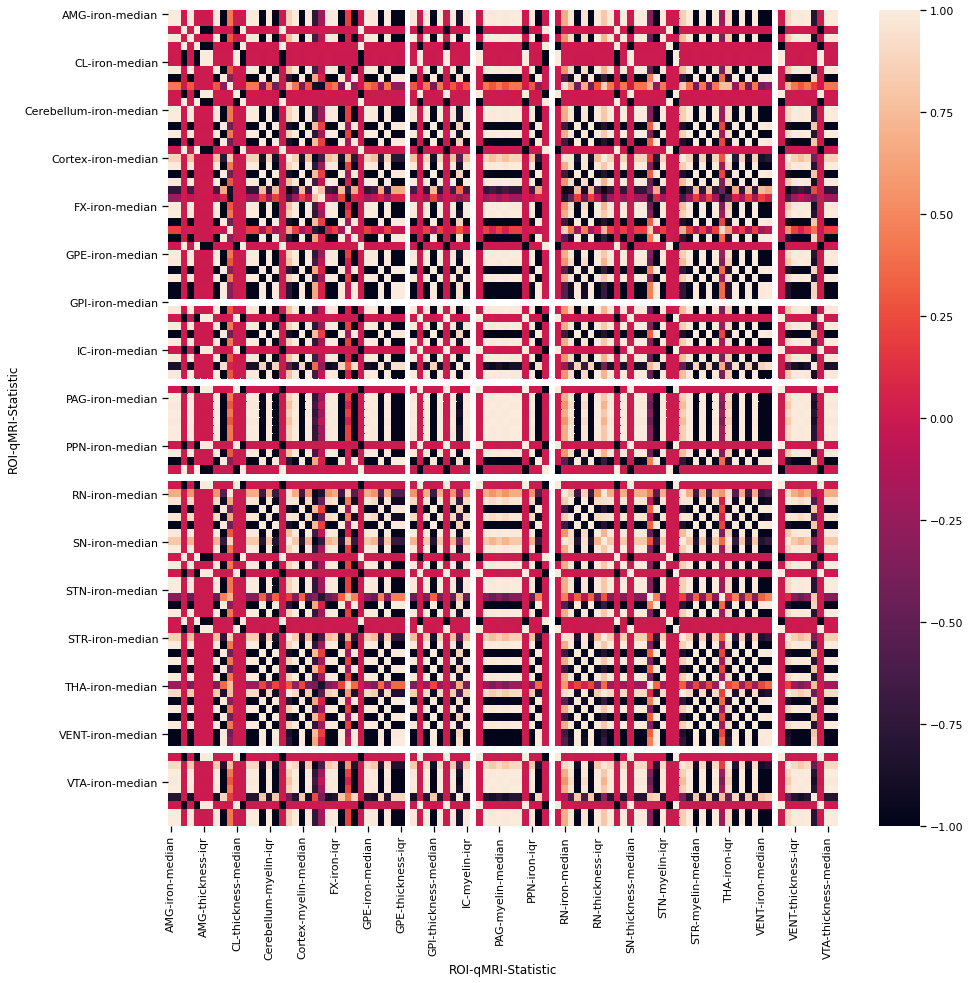

In [107]:
sns.heatmap(tmp.set_index(['ROI', 'qMRI', 'Statistic']).T.corr())

plt.gcf().set_size_inches(15,15)

In [109]:
sns.pairplot(tmp.set_index(['ROI', 'qMRI', 'Statistic']).T)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fba96c6af80> (for post_execute):


KeyboardInterrupt: 

In [110]:
summary_table

ivs  prediction_20yo  prediction_75yo  \
Statistic ROI  qMRI                                                            
iqr       AMG  iron                    Age         3.472231         4.551588   
               myelin                 Age2         2.332571         3.149814   
               thickness               sex         3.545602         3.545602   
          CL   iron                   Age2         2.492982         3.468716   
               myelin           Age + Age2         3.846073         4.055021   
...                                    ...              ...              ...   
median    VENT myelin                  sex         2.647454         2.647454   
               thickness       Age2 + Age4         3.558310         3.921360   
          VTA  iron                   Age2         3.906903         5.200470   
               myelin     sex + Age + Age2        15.065174        13.543946   
               thickness         sex + Age         1.638081         1.875509   

                          increase_pct  increase_pct_symm  
Statistic ROI  qMRI                                        
iqr       AMG  iron           1.310854           0.134519  
               myelin         1.350362           0.149067  
               thickness      1.000000           0.000000  
          CL   iron           1.391393           0.163667  
               myelin         1.054328           0.026445  
...                                ...                ...  
median    VENT myelin         1.000000           0.000000  
               thickness      1.102029           0.048538  
          VTA  iron           1.331098           0.142035  
               myelin         0.899023          -0.053173  
               thickness      1.144943           0.067574  

[102 rows x 5 columns]

In [132]:
summary_table = summary_table.reset_index()
summary_table['Effect'] = '-'
summary_table.loc[(summary_table.Statistic == 'iqr') & (summary_table.increase_pct > 1) & (summary_table.qMRI == 'iron'), 'Effect'] = 'Iron degradation'
summary_table.loc[(summary_table.Statistic == 'iqr') & (summary_table.increase_pct < 1) & (summary_table.qMRI == 'myelin'), 'Effect'] = 'Myelin degradation'
summary_table.loc[(summary_table.Statistic == 'iqr') & (summary_table.increase_pct < 1) & (summary_table.qMRI == 'thickness'), 'Effect'] = 'Decreased isotropy'
summary_table.loc[(summary_table.Statistic == 'iqr') & (summary_table.increase_pct > 1) & (summary_table.qMRI == 'thickness'), 'Effect'] = 'Increased isotropy'

summary_table.loc[(summary_table.Statistic == 'median') & (summary_table.increase_pct > 1) & (summary_table.qMRI == 'iron'), 'Effect'] = 'Iron deposition'
summary_table.loc[(summary_table.Statistic == 'median') & (summary_table.increase_pct < 1) & (summary_table.qMRI == 'iron'), 'Effect'] = 'Iron decrease'
summary_table.loc[(summary_table.Statistic == 'median') & (summary_table.increase_pct < 1) & (summary_table.qMRI == 'myelin'), 'Effect'] = 'Myelin decrease'
summary_table.loc[(summary_table.Statistic == 'median') & (summary_table.increase_pct > 1) & (summary_table.qMRI == 'myelin'), 'Effect'] = 'Myelin increase'
summary_table.loc[(summary_table.Statistic == 'median') & (summary_table.increase_pct < 1) & (summary_table.qMRI == 'thickness'), 'Effect'] = 'Decrease'
summary_table.loc[(summary_table.Statistic == 'median') & (summary_table.increase_pct > 1) & (summary_table.qMRI == 'thickness'), 'Effect'] = 'Increase'


In [133]:
summary_table.pivot_table(values=['increase_pct'], index=['ROI'], columns=['qMRI', 'Statistic']).round(2).to_csv('./summary_table_newIQR.csv')

In [134]:
summary_table.pivot_table(values=['increase_pct'], index=['ROI'], columns=['qMRI', 'Statistic'])['increase_pct']

qMRI            iron              myelin           thickness          
Statistic        iqr    median       iqr    median       iqr    median
ROI                                                                   
AMG         0.134519  0.233513  0.149067  0.000000  0.000000  0.000000
CL          0.163667  0.000000  0.026445 -0.052734  0.000000  0.000000
Cerebellum  0.109418  0.075925  0.063404 -0.075982  0.000000 -0.080044
Cortex      0.149030  0.088192  0.095952 -0.043618  0.029869 -0.030039
FX          0.083146  0.143249  0.005276 -0.182255  0.000000 -0.037971
GPE         0.194832  0.052376  0.197660 -0.172203 -0.092468 -0.075836
GPI         0.092840  0.000000  0.178021  0.000000  0.060321 -0.065248
IC          0.109711  0.000000  0.156507 -0.041117  0.000000  0.000000
PAG         0.108993  0.074626  0.080159 -0.040321  0.058058  0.066459
PPN         0.111603  0.000000  0.000000 -0.027178  0.000000  0.000000
RN          0.318424  0.118157  0.274254 -0.123119  0.176883 -0.121775
SN          0.064868  0.052416  0.111771  0.000000  0.082284  0.000000
STN         0.018144  0.105858  0.122793 -0.059621  0.000000  0.000000
STR         0.394771  0.137010  0.310521 -0.166933  0.032382 -0.111447
THA         0.151660 -0.024468  0.155736 -0.032038  0.047183 -0.025346
VENT       -0.186148  0.784851  0.000000  0.000000  0.032805  0.048538
VTA         0.110820  0.142035  0.000000 -0.053173  0.074487  0.067574

In [135]:
summary_table.pivot_table(values=['increase_pct'], index=['ROI'], columns=['qMRI', 'Statistic'])['increase_pct']

qMRI            iron              myelin           thickness          
Statistic        iqr    median       iqr    median       iqr    median
ROI                                                                   
AMG         0.134519  0.233513  0.149067  0.000000  0.000000  0.000000
CL          0.163667  0.000000  0.026445 -0.052734  0.000000  0.000000
Cerebellum  0.109418  0.075925  0.063404 -0.075982  0.000000 -0.080044
Cortex      0.149030  0.088192  0.095952 -0.043618  0.029869 -0.030039
FX          0.083146  0.143249  0.005276 -0.182255  0.000000 -0.037971
GPE         0.194832  0.052376  0.197660 -0.172203 -0.092468 -0.075836
GPI         0.092840  0.000000  0.178021  0.000000  0.060321 -0.065248
IC          0.109711  0.000000  0.156507 -0.041117  0.000000  0.000000
PAG         0.108993  0.074626  0.080159 -0.040321  0.058058  0.066459
PPN         0.111603  0.000000  0.000000 -0.027178  0.000000  0.000000
RN          0.318424  0.118157  0.274254 -0.123119  0.176883 -0.121775
SN          0.064868  0.052416  0.111771  0.000000  0.082284  0.000000
STN         0.018144  0.105858  0.122793 -0.059621  0.000000  0.000000
STR         0.394771  0.137010  0.310521 -0.166933  0.032382 -0.111447
THA         0.151660 -0.024468  0.155736 -0.032038  0.047183 -0.025346
VENT       -0.186148  0.784851  0.000000  0.000000  0.032805  0.048538
VTA         0.110820  0.142035  0.000000 -0.053173  0.074487  0.067574

In [136]:
plot_table = summary_table.pivot_table(values=['increase_pct'], index=['ROI'], columns=['qMRI', 'Statistic'])['increase_pct']
plot_table.loc['VENT', ('iron', 'median')] = 1
plot_table

qMRI            iron              myelin           thickness          
Statistic        iqr    median       iqr    median       iqr    median
ROI                                                                   
AMG         0.134519  0.233513  0.149067  0.000000  0.000000  0.000000
CL          0.163667  0.000000  0.026445 -0.052734  0.000000  0.000000
Cerebellum  0.109418  0.075925  0.063404 -0.075982  0.000000 -0.080044
Cortex      0.149030  0.088192  0.095952 -0.043618  0.029869 -0.030039
FX          0.083146  0.143249  0.005276 -0.182255  0.000000 -0.037971
GPE         0.194832  0.052376  0.197660 -0.172203 -0.092468 -0.075836
GPI         0.092840  0.000000  0.178021  0.000000  0.060321 -0.065248
IC          0.109711  0.000000  0.156507 -0.041117  0.000000  0.000000
PAG         0.108993  0.074626  0.080159 -0.040321  0.058058  0.066459
PPN         0.111603  0.000000  0.000000 -0.027178  0.000000  0.000000
RN          0.318424  0.118157  0.274254 -0.123119  0.176883 -0.121775
SN          0.064868  0.052416  0.111771  0.000000  0.082284  0.000000
STN         0.018144  0.105858  0.122793 -0.059621  0.000000  0.000000
STR         0.394771  0.137010  0.310521 -0.166933  0.032382 -0.111447
THA         0.151660 -0.024468  0.155736 -0.032038  0.047183 -0.025346
VENT       -0.186148  0.784851  0.000000  0.000000  0.032805  0.048538
VTA         0.110820  0.142035  0.000000 -0.053173  0.074487  0.067574

0.29247978750932313
0.8031554242192772
0.19511843484023692
-0.599043455540662
-0.2751275937131249
-0.3905252490264637
0.26533039506899436
0.08554993454128403
0.2873919021084895
0.13828206585015285
-0.6689200743018809
-0.07502811769443776
-0.7087829524196667
0.5705022539305633
-0.08110327004074844


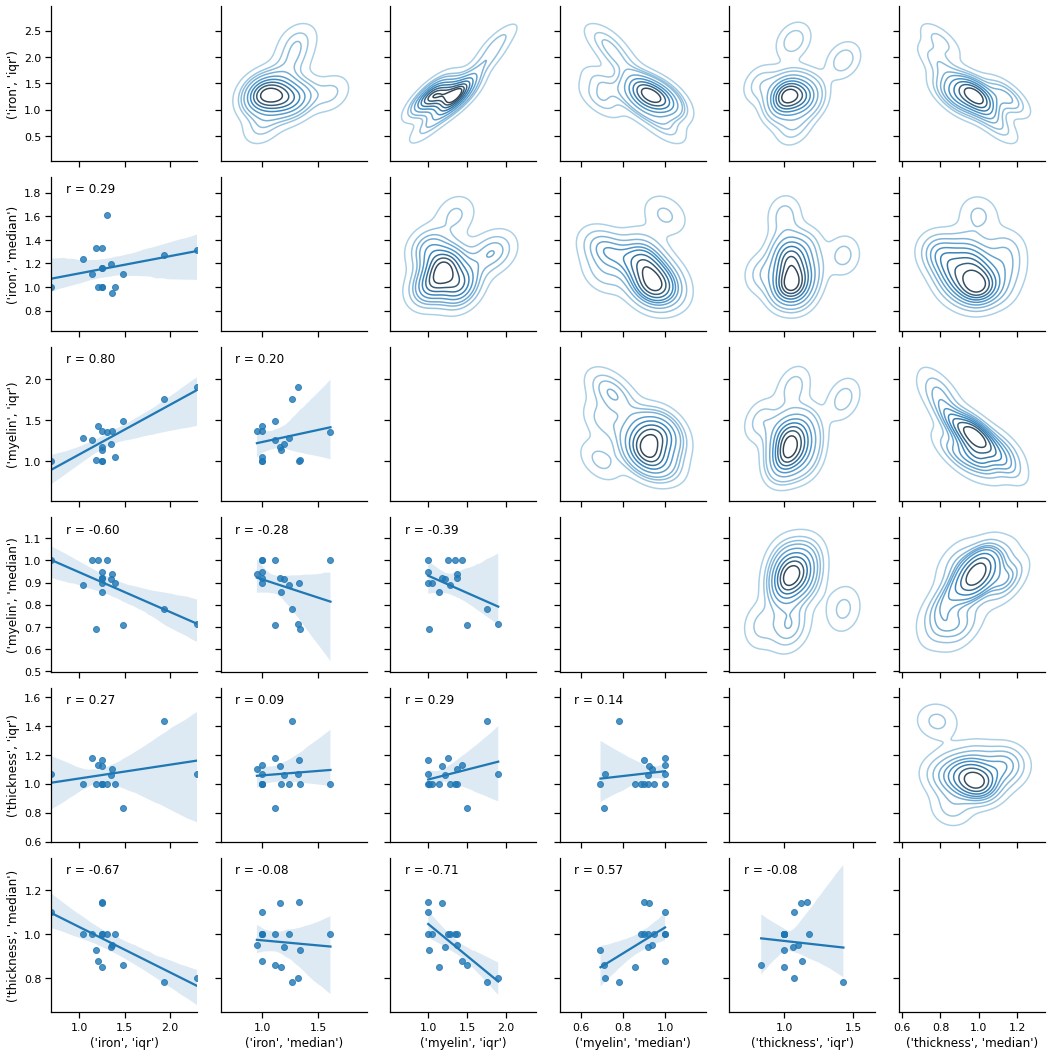

In [117]:
from scipy import stats
sns.set_context('notebook')
g = sns.PairGrid(plot_table)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    print(r)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
#g.map_lower(plt.scatter, s=10)
g.map_lower(sns.regplot)
g.map_lower(corrfunc)
# g.map_diag(sns.distplot)
g.map_upper(sns.kdeplot, cmap="Blues_d")

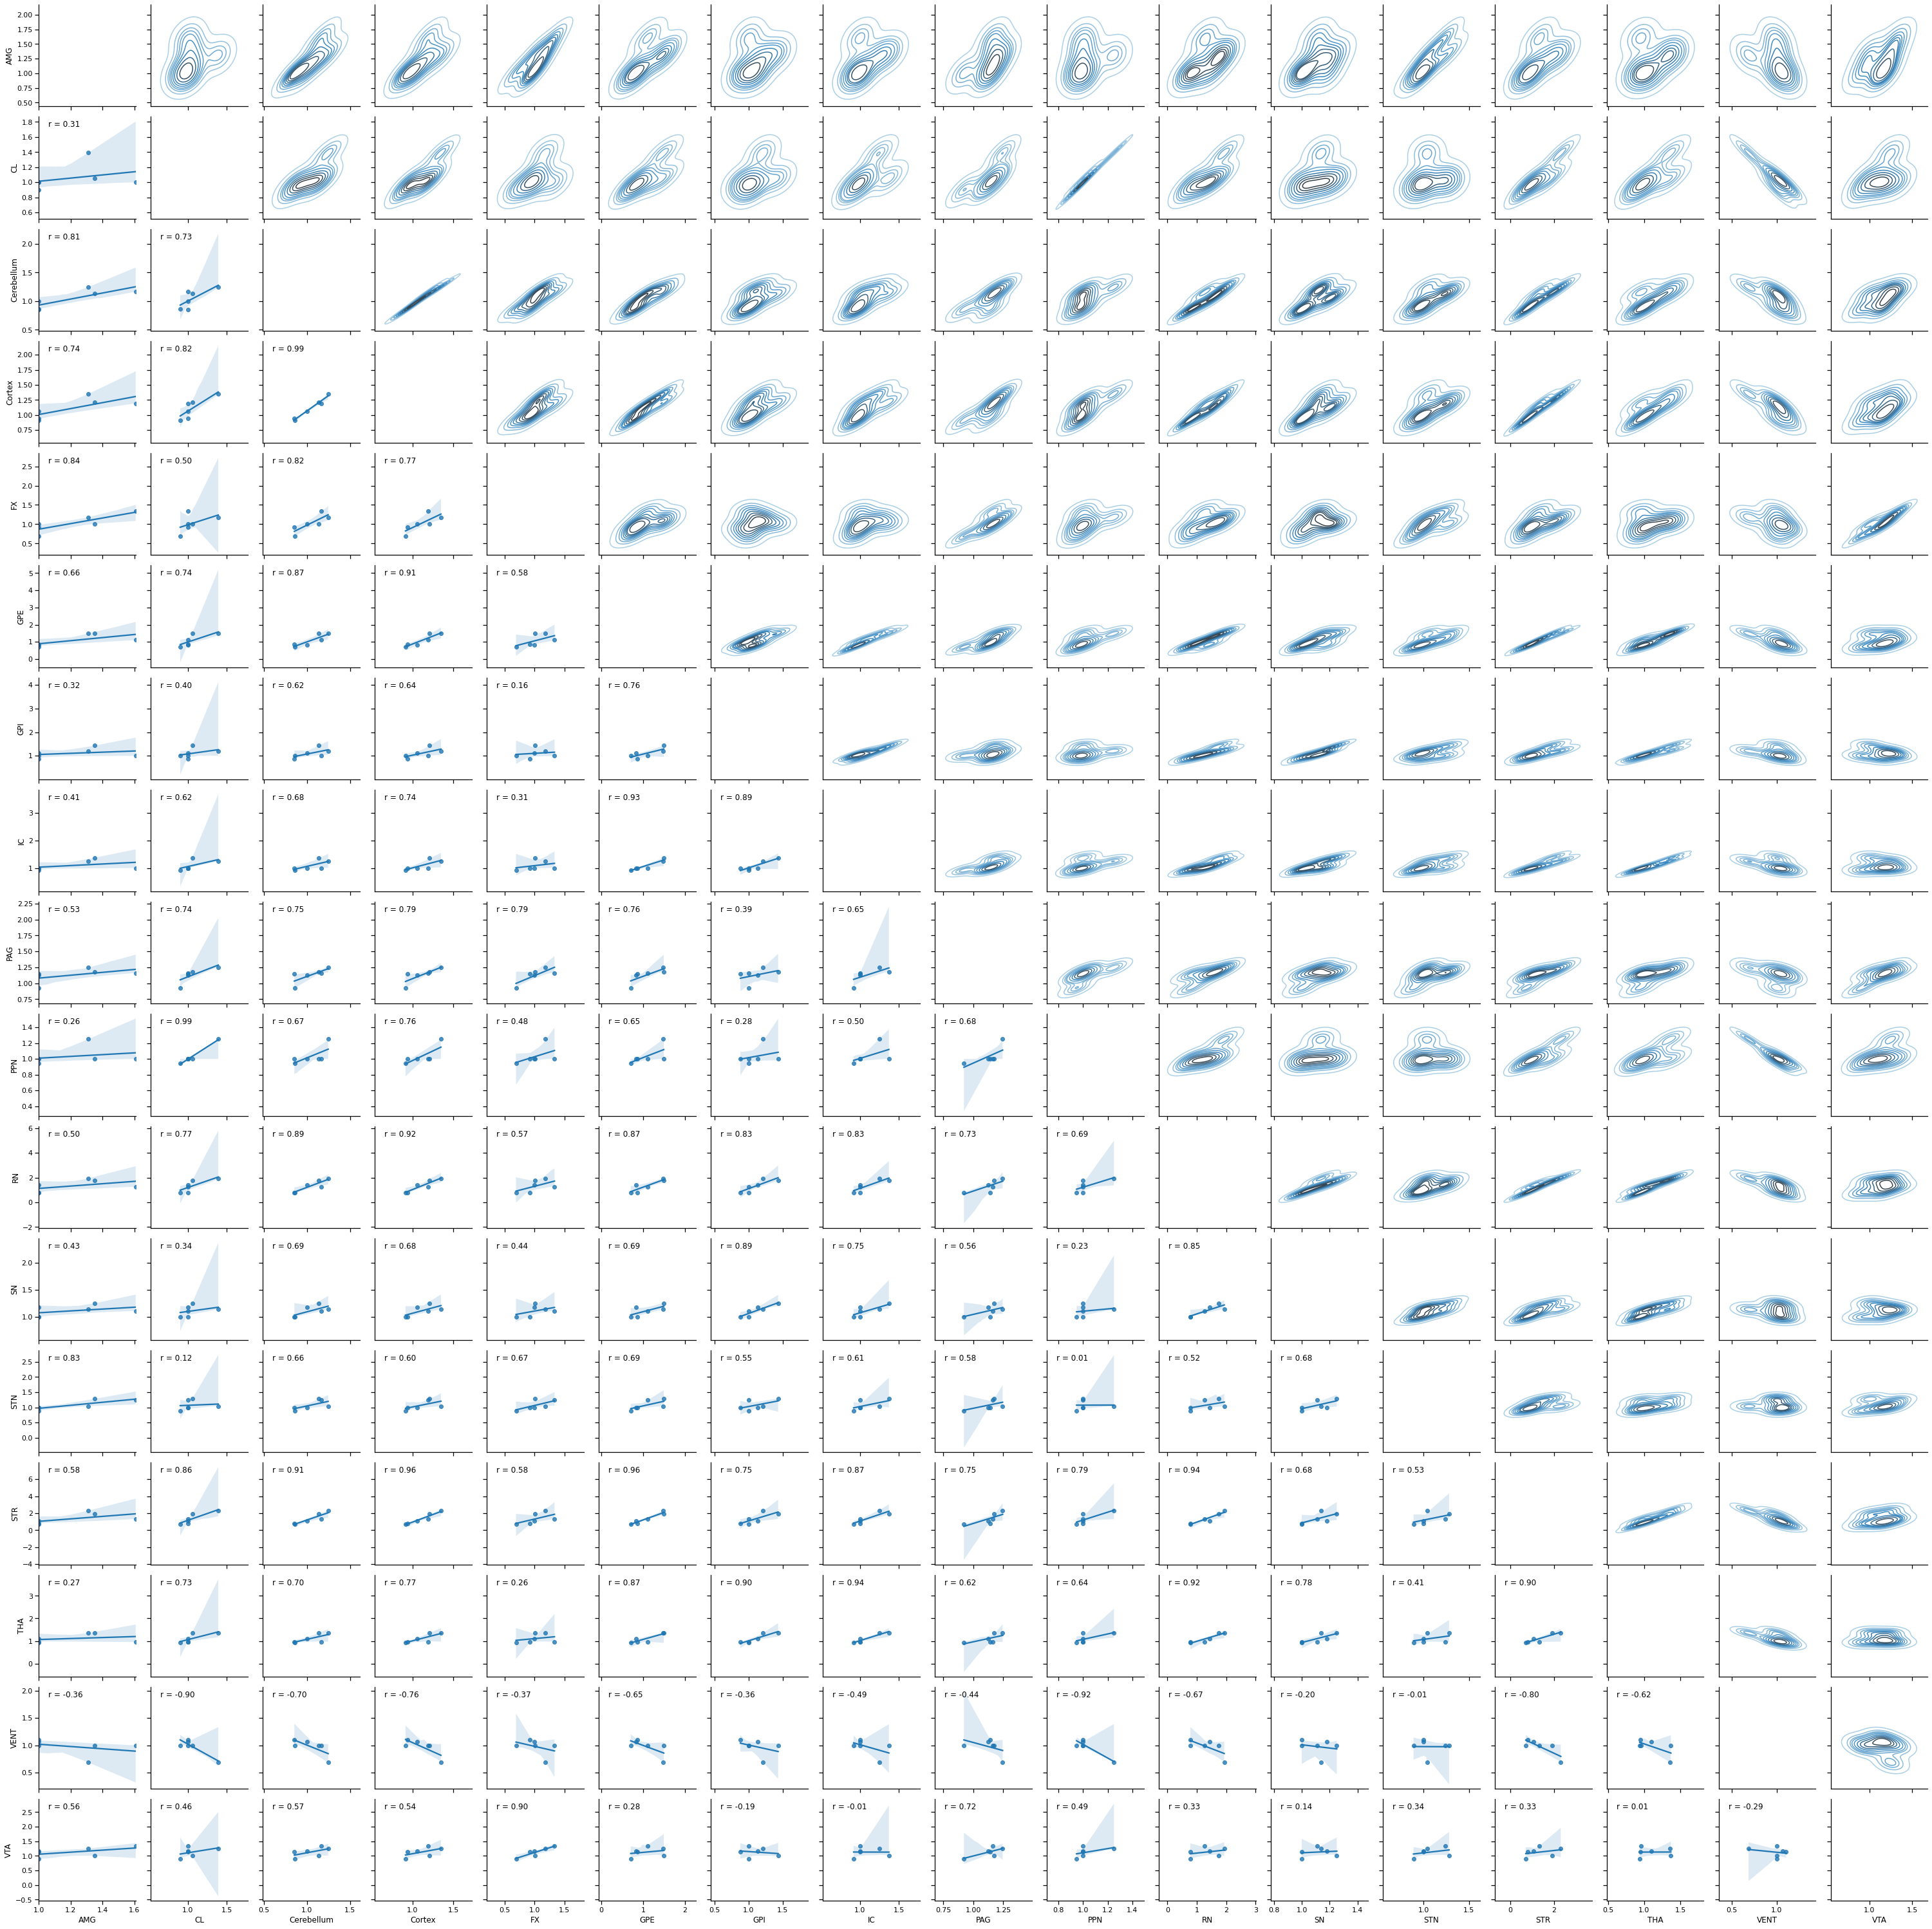

In [118]:
from scipy import stats
sns.set_context('notebook')
g = sns.PairGrid(plot_table.T)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    #print(r)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
#g.map_lower(plt.scatter, s=10)
g.map_lower(sns.regplot)
g.map_lower(corrfunc)
# g.map_diag(sns.distplot)
g.map_upper(sns.kdeplot, cmap="Blues_d")

<AxesSubplot:xlabel='ROI', ylabel='ROI'>

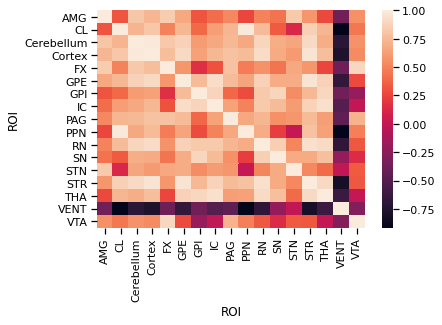

In [120]:
sns.heatmap(plot_table.T.corr())

<AxesSubplot:xlabel='ROI', ylabel='ROI'>

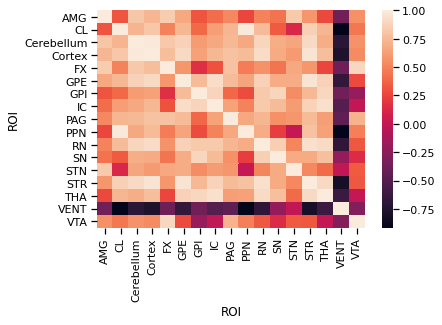

In [119]:
sns.heatmap(plot_table.T.corr())

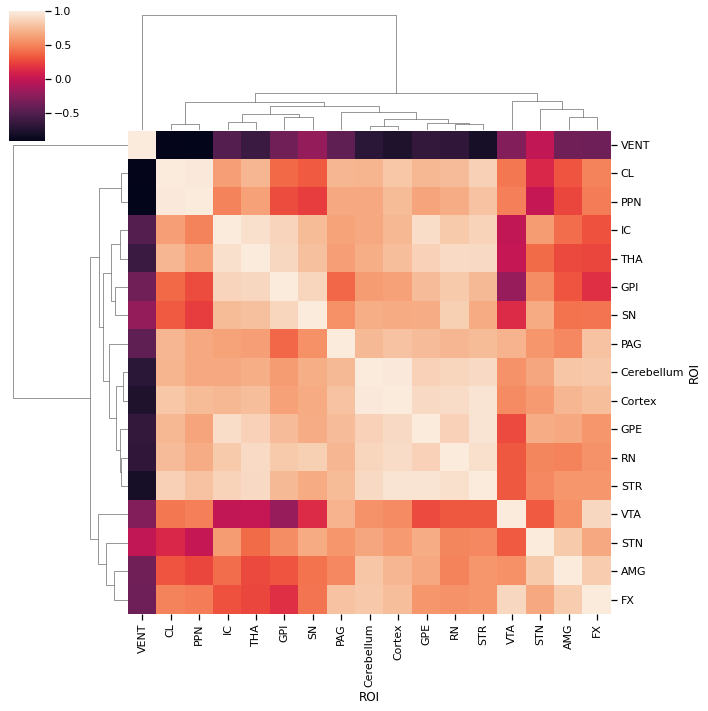

In [121]:
sns.clustermap(plot_table.T.corr())

In [58]:
tmp = summary_table.pivot_table(values=['increase_pct'], index=['ROI'], columns=['qMRI', 'Statistic'])['increase_pct']

In [59]:
tmp[tmp<1] = 2-tmp[tmp<1]
tmp['ageing_index'] = tmp.sum(1)-6 #).sort_values()#.values

In [61]:
tmp.round(2).to_csv('./summary_table_newIQR_indexed.csv')

In [62]:
tmp

qMRI            iron              myelin           thickness            \
Statistic        iqr    median       iqr    median       iqr    median   
ROI                                                                      
AMG         1.310854  1.609306  1.350362  1.000000  1.000000  1.000000   
CL          1.391393  1.000000  1.054328  1.096606  1.000000  1.000000   
Cerebellum  1.245722  1.164326  1.135392  1.141233  1.000000  1.136714   
Cortex      1.350259  1.193444  1.212273  1.083590  1.061577  1.058326   
FX          1.181372  1.334400  1.010608  1.308318  1.000000  1.073165   
GPE         1.483953  1.110542  1.492709  1.293810  1.169283  1.143585   
GPI         1.204682  1.000000  1.433151  1.000000  1.128387  1.122502   
IC          1.246461  1.000000  1.371092  1.078209  1.000000  1.000000   
PAG         1.244652  1.161289  1.185896  1.005100  1.123273  1.145812   
PPN         1.251246  1.000000  1.000000  1.051592  1.000000  1.000000   
RN          1.934377  1.267978  1.755786  1.219245  1.429787  1.217111   
SN          1.138735  1.110631  1.251672  1.000000  1.179324  1.000000   
STN         1.185343  1.236781  1.279964  1.109022  1.000000  1.000000   
STR         2.304532  1.317523  1.900741  1.286105  1.066931  1.200544   
THA         1.357546  1.047767  1.223113  1.062088  1.102077  1.010125   
VENT        1.313870  8.295900  1.000000  1.000000  1.067836  1.102029   
VTA         1.249264  1.331098  1.000000  1.097952  1.160964  1.149824   

qMRI       ageing_index  
Statistic                
ROI                      
AMG            1.270522  
CL             0.542326  
Cerebellum     0.823388  
Cortex         0.959468  
FX             0.907863  
GPE            1.693883  
GPI            0.888721  
IC             0.695761  
PAG            0.866022  
PPN            0.302838  
RN             2.824283  
SN             0.680363  
STN            0.811111  
STR            3.076377  
THA            0.802715  
VENT           7.779634  
VTA            0.989103

In [70]:
tmp = summary_table.loc[~summary_table.ROI.isin(['Cerebellum', 'Cortex'])].pivot_table(values=['increase_pct'], index=['ROI'], columns=['qMRI', 'Statistic'])['increase_pct']

In [64]:
tmp

qMRI            iron              myelin           thickness            \
Statistic        iqr    median       iqr    median       iqr    median   
ROI                                                                      
AMG         1.310854  1.609306  1.350362  1.000000  1.000000  1.000000   
CL          1.391393  1.000000  1.054328  1.096606  1.000000  1.000000   
Cerebellum  1.245722  1.164326  1.135392  1.141233  1.000000  1.136714   
Cortex      1.350259  1.193444  1.212273  1.083590  1.061577  1.058326   
FX          1.181372  1.334400  1.010608  1.308318  1.000000  1.073165   
GPE         1.483953  1.110542  1.492709  1.293810  1.169283  1.143585   
GPI         1.204682  1.000000  1.433151  1.000000  1.128387  1.122502   
IC          1.246461  1.000000  1.371092  1.078209  1.000000  1.000000   
PAG         1.244652  1.161289  1.185896  1.005100  1.123273  1.145812   
PPN         1.251246  1.000000  1.000000  1.051592  1.000000  1.000000   
RN          1.934377  1.267978  1.755786  1.219245  1.429787  1.217111   
SN          1.138735  1.110631  1.251672  1.000000  1.179324  1.000000   
STN         1.185343  1.236781  1.279964  1.109022  1.000000  1.000000   
STR         2.304532  1.317523  1.900741  1.286105  1.066931  1.200544   
THA         1.357546  1.047767  1.223113  1.062088  1.102077  1.010125   
VENT        1.313870  8.295900  1.000000  1.000000  1.067836  1.102029   
VTA         1.249264  1.331098  1.000000  1.097952  1.160964  1.149824   

qMRI       ageing_index  
Statistic                
ROI                      
AMG            1.270522  
CL             0.542326  
Cerebellum     0.823388  
Cortex         0.959468  
FX             0.907863  
GPE            1.693883  
GPI            0.888721  
IC             0.695761  
PAG            0.866022  
PPN            0.302838  
RN             2.824283  
SN             0.680363  
STN            0.811111  
STR            3.076377  
THA            0.802715  
VENT           7.779634  
VTA            0.989103

In [79]:
tmp[tmp<1] = 2-tmp[tmp<1]

In [86]:
(tmp.sum(1)-6).sort_values()#.values

ROI
SN      0.414456
VENT    0.456325
PAG     0.469853
PPN     0.580234
STN     0.627058
CL      0.729403
VTA     0.800031
FX      0.975396
AMG     0.992141
THA     1.055926
GPI     1.062494
IC      1.481509
GPE     1.614247
STR     3.631638
RN      3.779898
dtype: float64

In [ ]:
# def get_area_under_curve(result):
#     age_range = np.arange(19, 81)
#     predict_df_0 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 0})
#     predict_df_1 = pd.DataFrame({'Age': age_range, 'Age2': age_range**2, 'sex': 1})

#     all_predictions_1 = np.abs(result.predict(predict_df_1))
#     area_under_curve_1 = all_predictions_1.sum() - ((81-19)*np.min(all_predictions_1))
#     all_predictions_0 = np.abs(result.predict(predict_df_0))
#     area_under_curve_0 = all_predictions_1.sum() - ((81-19)*np.min(all_predictions_0))
#     return np.mean([area_under_curve_0, area_under_curve_1])

# winning_model_df['AUC'] = winning_model_df['result'].apply(get_area_under_curve)